# Figures

Peaks / lengths / differences / jaccard etc.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

sns.set_theme(style="whitegrid")

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None, usecols=[1, 2])
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load peaks


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

ABF_PATH = os.path.expanduser('~/data/2018_chipseq_y20o20')
ABF_MODIFICATIONS = ['k4me3', 'k27ac', 'k4me1', 'k27me3', 'k36me3']
ABF_REPLICATES = [f'OD{i}' for i in range(1, 30)] + [f'YD{i}' for i in range(1, 30)]

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics
! mkdir -p {ABF_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'Peakseq', 'LanceOtron', 'SPAN']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    if not os.path.exists(path):
        return df
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        mod = next((m for m in modifications if f'{m}_' in f), None)
        cell = '' if '' in cells else next((c for c in cells if f'{c}_' in f), None)
        rep = next((r for r in replicates if f'_{r}_' in f or f'_{r}-' in f or f'_{r}.' in f or f.startswith(f'{r}_')),
                   None)
        if rep is None and '' in replicates:
            rep = ''
        if mod and cell is not None and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    df_homer = load_peaks(os.path.join(path, 'homer'), '.peaks', modifications, cells, replicates)
    df_homer['tool'] = 'HOMER'
    print('HOMER', len(df_homer))

    df_hotspot = load_peaks(os.path.join(path, 'hotspot'), '.peak', modifications, cells, replicates)
    df_hotspot['tool'] = 'Hotspot'
    print('Hotspot', len(df_hotspot))

    df_peakseq = load_peaks(os.path.join(path, 'peakseq'), '.narrowPeak', modifications, cells, replicates)
    df_peakseq['tool'] = 'Peakseq'
    print('Peakseq', len(df_peakseq))

    df_lanceotron = load_peaks(os.path.join(path, 'lanceotron'), '.bed', modifications, cells, replicates)
    df_lanceotron['tool'] = 'LanceOtron'
    print('LanceOtron', len(df_lanceotron))

    return pd.concat(
        [df_macs2, df_macs2broad, df_sicer, df_span, df_homer, df_hotspot, df_peakseq, df_lanceotron]
    ).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/1038 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/85 [00:00<?, ?it/s]

HOMER 85


  0%|          | 0/85 [00:00<?, ?it/s]

Hotspot 85


  0%|          | 0/171 [00:00<?, ?it/s]

Peakseq 85


  0%|          | 0/255 [00:00<?, ?it/s]

LanceOtron 85


file modification     cell  \
320  /home/jetbrains/data/2023_GSE26320/span/GSM646...     H3K27me3       H1   
441  /home/jetbrains/data/2023_GSE26320/hotspot/GSM...      H3K4me3    Huvec   
236  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...     H3K27me3     NHLF   
601  /home/jetbrains/data/2023_GSE26320/lanceotron/...      H3K4me3     HSMM   
160  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K27me3  GM12878   

    replicate  peaks         tool dataset  
320      rep2  13551         SPAN  ENCODE  
441      rep2  76023      Hotspot  ENCODE  
236      rep1  28080        SICER  ENCODE  
601      rep2  83256   LanceOtron  ENCODE  
160      rep1     50  MACS2 broad  ENCODE

In [8]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/562 [00:00<?, ?it/s]

SPAN 46


  0%|          | 0/46 [00:00<?, ?it/s]

HOMER 46


  0%|          | 0/46 [00:00<?, ?it/s]

Hotspot 46


  0%|          | 0/94 [00:00<?, ?it/s]

Peakseq 46


  0%|          | 0/138 [00:00<?, ?it/s]

LanceOtron 46


file modification   cell  \
60   /home/jetbrains/data/2023_Immune/macs2/CD4_H3K...     H3K36me3    CD4   
20   /home/jetbrains/data/2023_Immune/macs2/CD34_H3...      H3K4me1   CD34   
46   /home/jetbrains/data/2023_Immune/macs2/CD34_H3...      H3K27ac   CD34   
74   /home/jetbrains/data/2023_Immune/macs2/CD4_H3K...     H3K36me3    CD4   
211  /home/jetbrains/data/2023_Immune/homer/BCell_H...      H3K27ac  BCell   

    replicate   peaks         tool  dataset  
60       rep1     120  MACS2 broad  Roadmap  
20             153731        MACS2  Roadmap  
46       rep2   29558  MACS2 broad  Roadmap  
74             107518  MACS2 broad  Roadmap  
211             27040        HOMER  Roadmap

In [9]:
def update_abf_modifications(df):
    df.loc[df['modification'] == 'k4me3', 'modification'] = 'H3K4me3'
    df.loc[df['modification'] == 'k27ac', 'modification'] = 'H3K27ac'
    df.loc[df['modification'] == 'k4me1', 'modification'] = 'H3K4me1'
    df.loc[df['modification'] == 'k27me3', 'modification'] = 'H3K27me3'
    df.loc[df['modification'] == 'k36me3', 'modification'] = 'H3K36me3'

In [10]:
df_abf_peaks_all = load_peaks_path(ABF_PATH, ABF_MODIFICATIONS, [''], ABF_REPLICATES)
update_abf_modifications(df_abf_peaks_all)
df_abf_peaks_all['cell'] = ['OD' if 'OD' in r else 'YD' for r in df_abf_peaks_all['replicate']]
df_abf_peaks_all['dataset'] = 'ABF'
# Drop outliers
ABF_OUTLIERS = {'k27ac': ['YD1', 'YD6'],
                'k27me3': ['OD9', 'YD1', 'YD2', 'YD3', 'YD4', 'YD9', 'YD10', 'YD11'],
                'k36me3': ['OD3', 'OD6', 'OD12', 'OD18', 'OD20', 'YD1', 'YD3', 'YD4', 'YD5'],
                'k4me3': ['OD6', 'OD7', 'OD14', 'YD2', 'YD3', 'YD10', 'YD14']}
t_outliers = [any(f'{o}_h3{m}'.lower() in f.lower() or f'{o}_{m}'.lower() in f.lower()
                  for m, ol in ABF_OUTLIERS.items() for o in ol)
              for f in df_abf_peaks_all['file']]
print('Total outliers', sum(t_outliers))
df_abf_peaks = df_abf_peaks_all[[not to for to in t_outliers]]

df_abf_peaks.sample(5)

  0%|          | 0/1528 [00:00<?, ?it/s]

MACS2 191


  0%|          | 0/1528 [00:00<?, ?it/s]

MACS2 broad 191


  0%|          | 0/191 [00:00<?, ?it/s]

SICER 191


  0%|          | 0/2293 [00:00<?, ?it/s]

SPAN 191


  0%|          | 0/191 [00:00<?, ?it/s]

HOMER 191


  0%|          | 0/191 [00:00<?, ?it/s]

Hotspot 191


  0%|          | 0/383 [00:00<?, ?it/s]

Peakseq 191


  0%|          | 0/542 [00:00<?, ?it/s]

LanceOtron 191
Total outliers 208


file modification cell  \
1082  /home/jetbrains/data/2018_chipseq_y20o20/hotsp...      H3K4me3   YD   
442   /home/jetbrains/data/2018_chipseq_y20o20/sicer...     H3K36me3   OD   
1317  /home/jetbrains/data/2018_chipseq_y20o20/peaks...      H3K27ac   OD   
453   /home/jetbrains/data/2018_chipseq_y20o20/sicer...     H3K27me3   OD   
1284  /home/jetbrains/data/2018_chipseq_y20o20/peaks...     H3K36me3   OD   

     replicate   peaks     tool dataset  
1082       YD4  614941  Hotspot     ABF  
442        OD2   37833    SICER     ABF  
1317       OD1   54674  Peakseq     ABF  
453        OD7   29697    SICER     ABF  
1284      OD13  218491  Peakseq     ABF

In [11]:
df_peaks_full = pd.concat([df_encode_peaks, df_immune_peaks, df_abf_peaks]).reset_index(drop=True)

In [12]:
# Remove outliers
OUTLIERS = [
    ('H3K4me3', 'NK', ''),
    ('H3K27ac', 'CD34', 'rep2'),
    ('H3K4me1', 'NK', ''),
    ('H3K27me3', 'BCell', ''),
    ('H3K27me3', 'TCell', ''),
    ('H3K27me3', 'NK', ''),
]
df_peaks = df_peaks_full.loc[[(m, c, r) not in OUTLIERS
                              for _, (m, c, r) in
                              df_peaks_full[['modification', 'cell', 'replicate']].iterrows()]].copy()

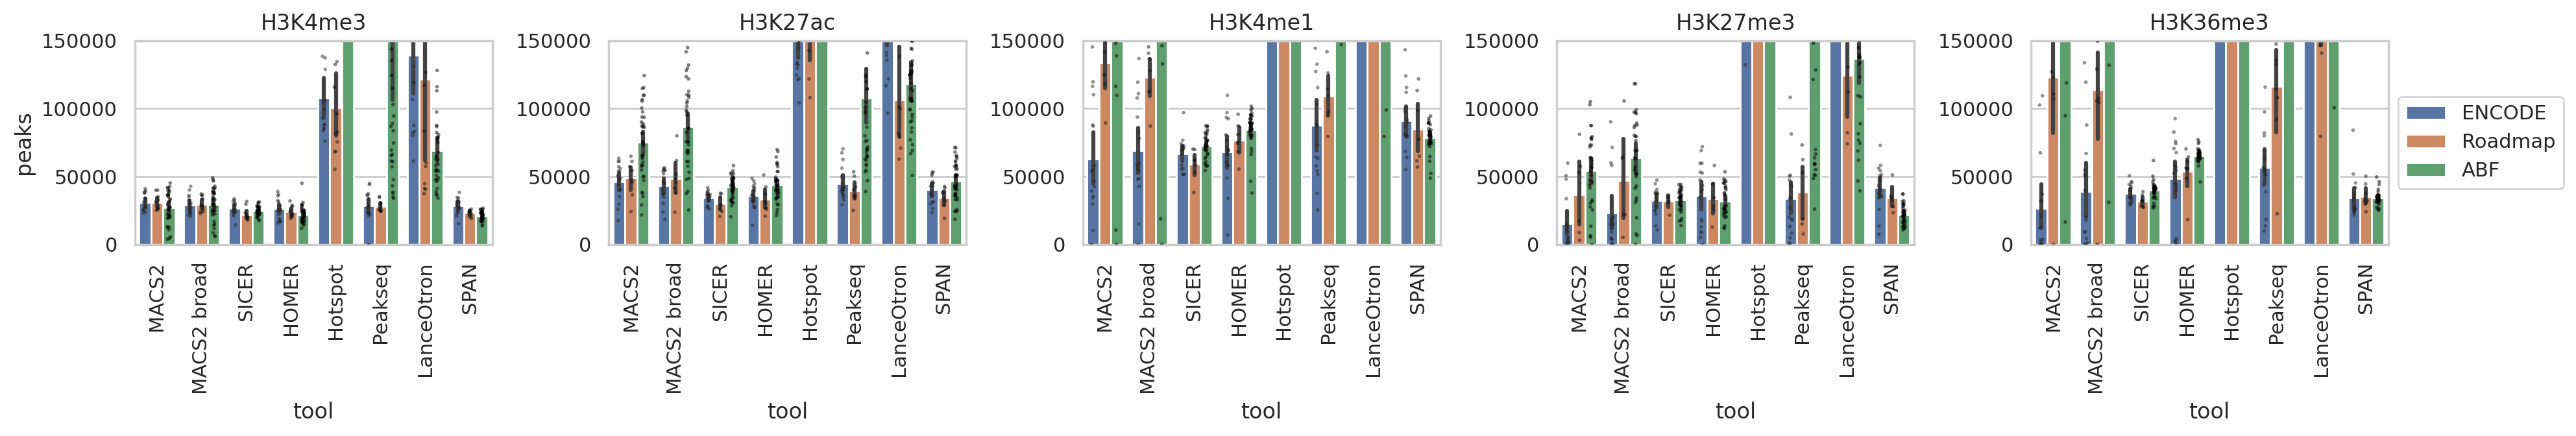

In [13]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    dfm = df_peaks[df_peaks['modification'] == m]
    sns.barplot(data=dfm, x='tool', y='peaks', hue='dataset',
                # capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.stripplot(data=dfm, x='tool', y='peaks', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.5,
                  order=TOOLS,
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(bottom=0, top=150_000)
plt.tight_layout()
plt.show()

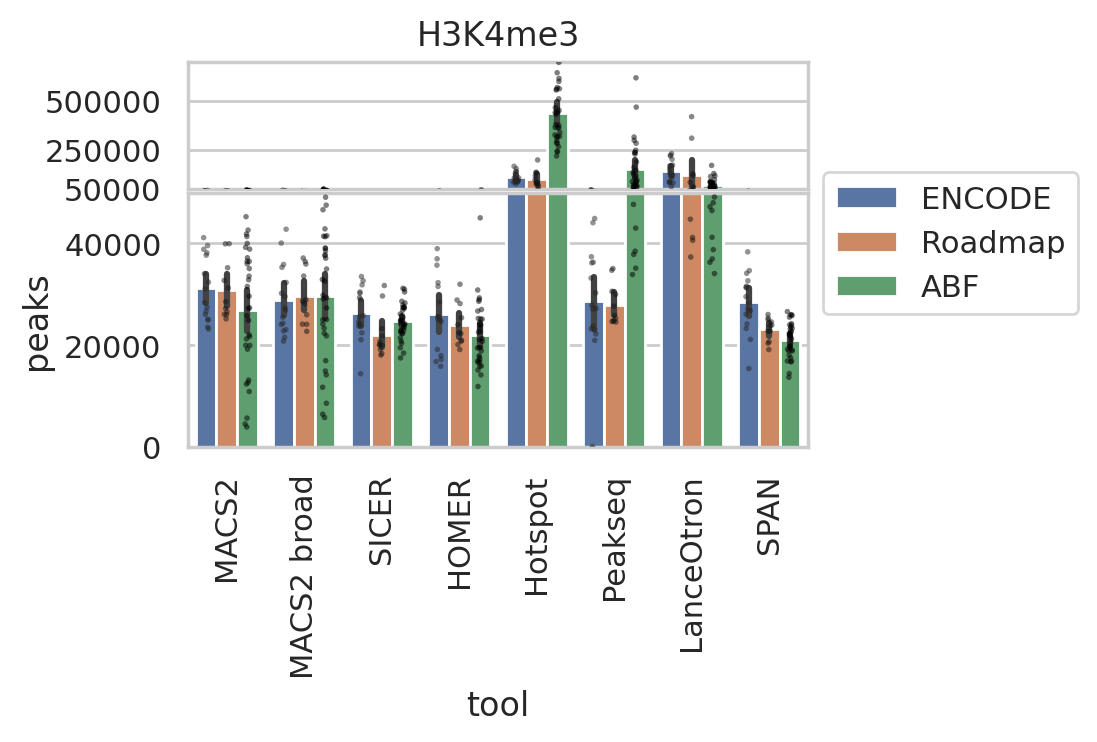

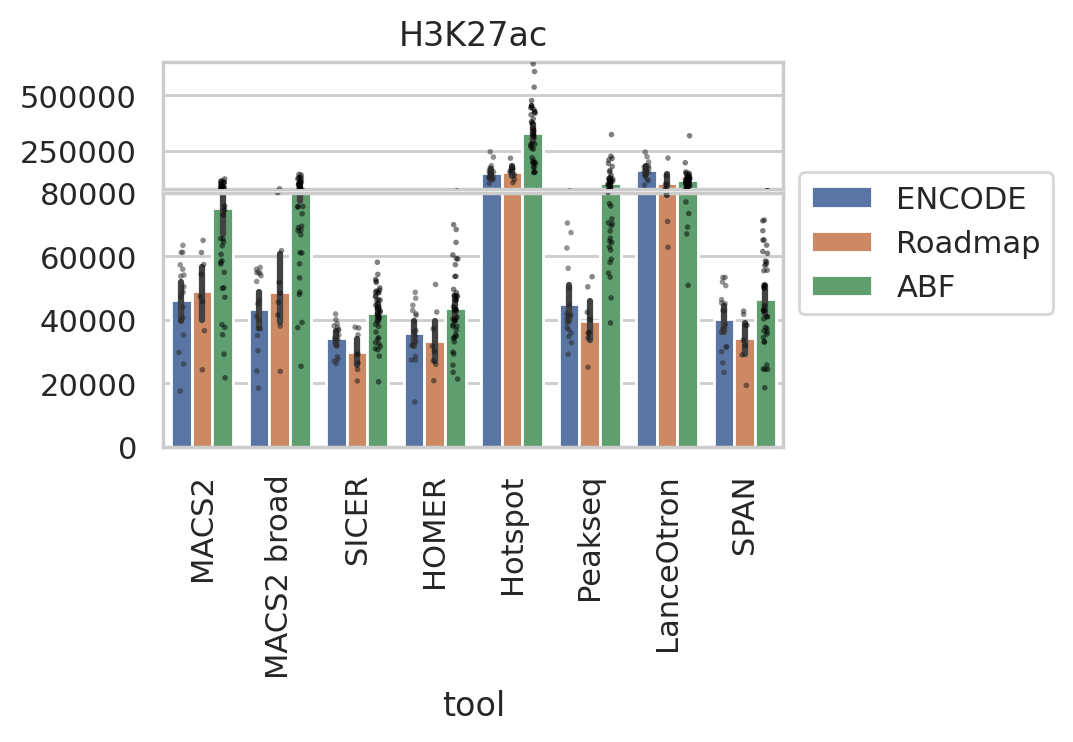

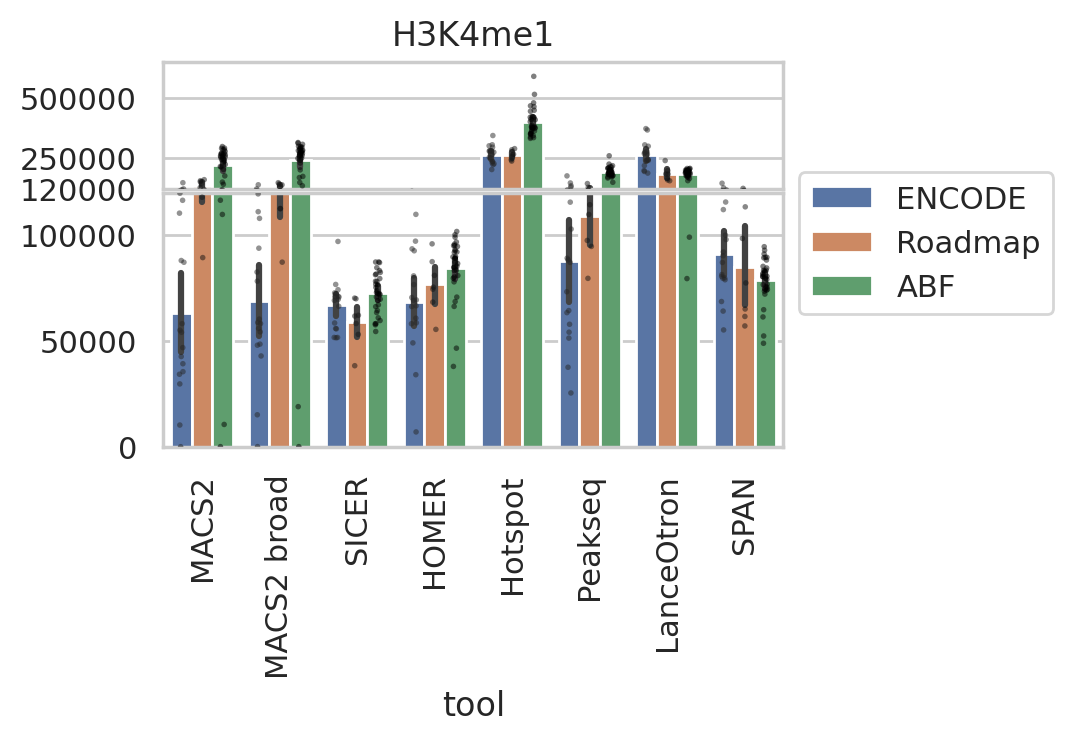

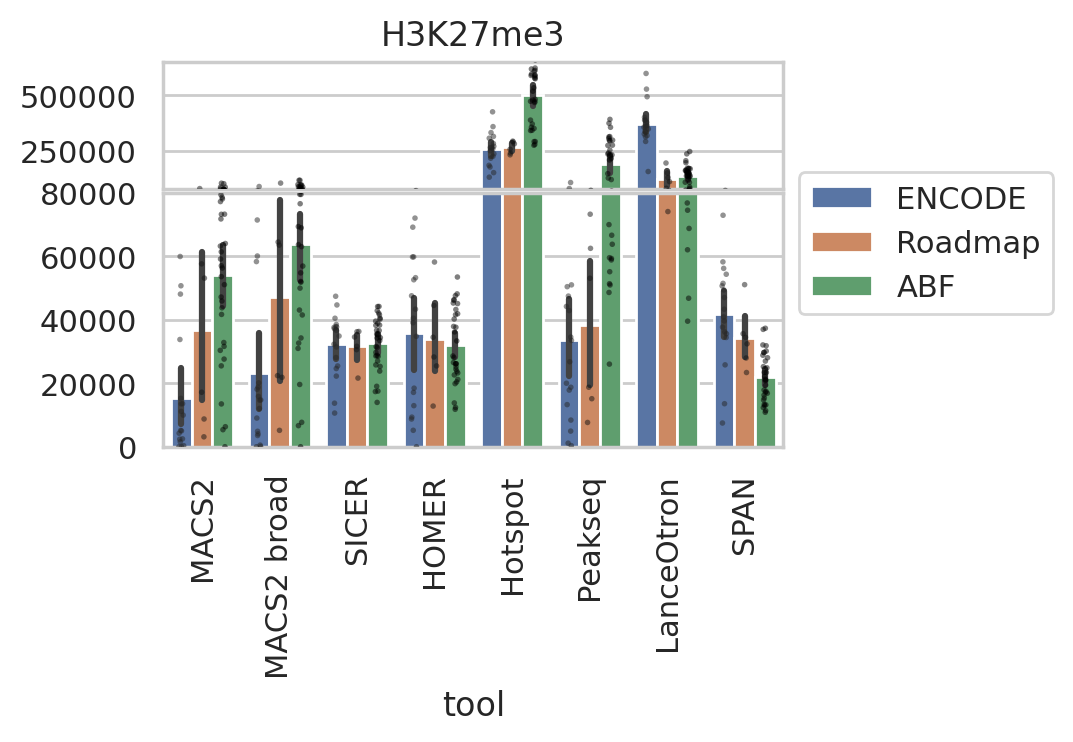

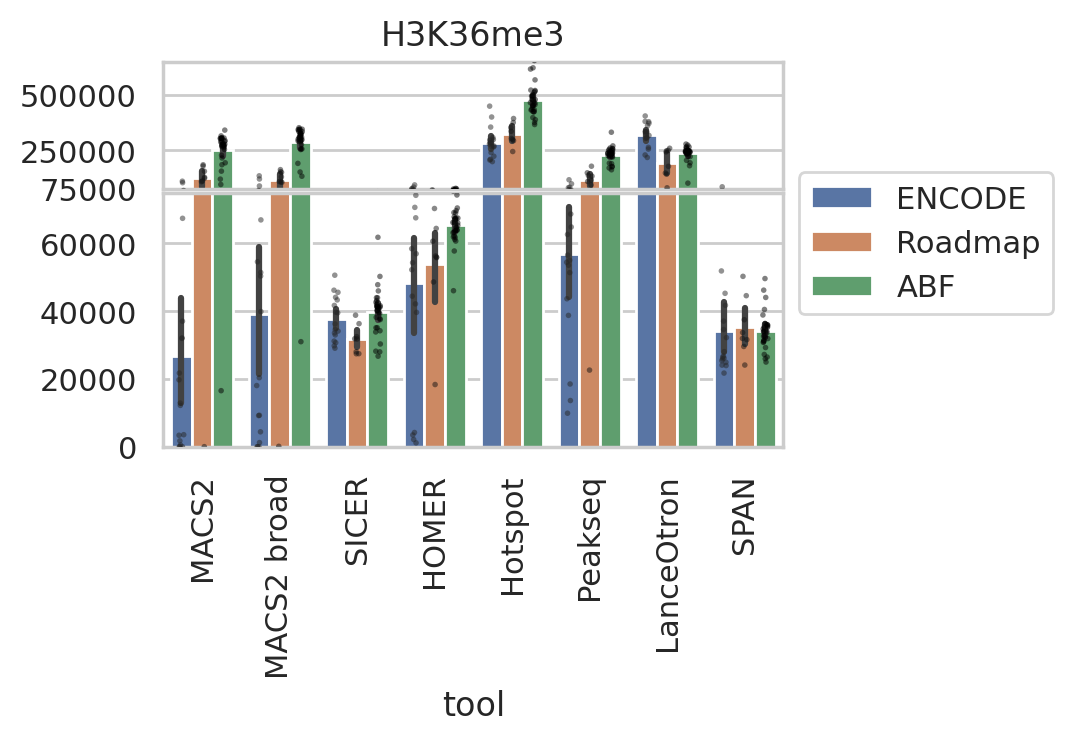

In [14]:
sns.set_style('whitegrid')
for i, m in enumerate(MODIFICATIONS):
    dfm = df_peaks[df_peaks['modification'] == m]
    # Set up the matplotlib figure with broken y-axis
    f, (axt, ax) = plt.subplots(2, 1, sharex=True, figsize=(4, 2.5),
                                gridspec_kw={'height_ratios': [1, 2]})
    for j, axes in enumerate([ax, axt]):
        sns.barplot(data=dfm, x='tool', y='peaks', hue='dataset',
                    order=TOOLS,
                    hue_order=['ENCODE', 'Roadmap', 'ABF'],
                    ax=axes)
        sns.stripplot(data=dfm, x='tool', y='peaks', hue='dataset',
                      dodge=True, size=2, palette='dark:black', alpha=0.5,
                      order=TOOLS,
                      hue_order=['ENCODE', 'Roadmap', 'ABF'],
                      legend=False,
                      ax=axes)
    if m == 'H3K4me3':
        ax.set_ylim(bottom=0, top=50_000)
        axt.set_ylim(bottom=50_000, top=700_000)
        axt.set_yticks([50_000, 250_000, 500_000])
    elif m == 'H3K27ac':
        ax.set_ylim(bottom=0, top=80_000)
        axt.set_ylim(bottom=80_000, top=650_000)
        axt.set_yticks([250_000, 500_000])
    elif m == 'H3K4me1':
        ax.set_ylim(bottom=0, top=120_000)
        axt.set_ylim(bottom=120_000, top=650_000)
        axt.set_yticks([120_000, 250_000, 500_000])
    elif m == 'H3K27me3':
        ax.set_ylim(bottom=0, top=80_000)
        axt.set_ylim(bottom=80_000, top=650_000)
        axt.set_yticks([250_000, 500_000])
    elif m == 'H3K36me3':
        ax.set_ylim(bottom=0, top=75_000)
        axt.set_ylim(bottom=75_000, top=650_000)
        axt.set_yticks([75_000, 250_000, 500_000])

    axt.set_xlabel(None)
    axt.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)
    axt.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    axt.legend().set_visible(False)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    # plt.tight_layout()
    plt.subplots_adjust(hspace=0.02)  # Adjust hspace closer to zero to remove spacing
    plt.show()

# Lengths

In [15]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(list(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
))):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    t['footprint'] = sum(lengths)
    ts.append(t)
df_lens = pd.concat(ts).reset_index(drop=True)
del ts, t
df_lens.sample(10)

Load lengths


  0%|          | 0/2320 [00:00<?, ?it/s]

length  dataset modification  cell replicate        tool  footprint
14783570    635.0      ABF      H3K4me3    OD      OD15        SPAN   21461760
9119506    2027.0  Roadmap      H3K27ac    NK               Peakseq   42694682
18510901    354.0      ABF     H3K36me3    YD      YD18     Hotspot  287962062
6380575     271.0   ENCODE      H3K27ac  NHLF      rep1  LanceOtron  113238368
13902164  10599.0      ABF      H3K27ac    YD      YD11       SICER  386988711
10670432    289.0      ABF     H3K27me3    YD      YD15       MACS2    2506919
20008397    201.0      ABF     H3K27me3    YD      YD19     Peakseq   29816992
449208      255.0   ENCODE     H3K27me3  HSMM      rep1       MACS2    1696548
133623      675.0   ENCODE      H3K4me1  HMEC      rep1       MACS2    4478311
4010127       0.0   ENCODE      H3K4me1  HMEC      rep1     Hotspot  192571882

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


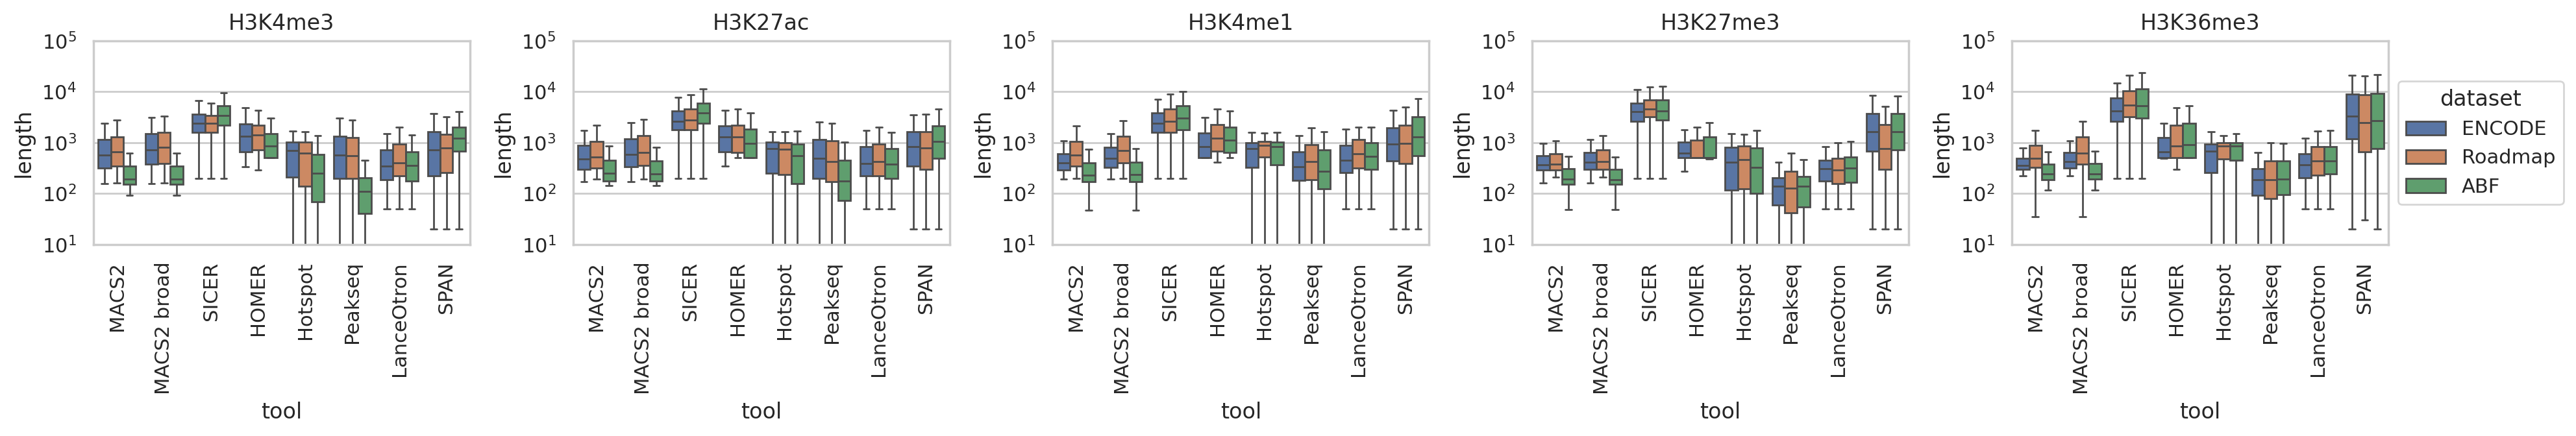

In [16]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens[df_lens['modification'] == m], x='tool', y='length', hue='dataset',
                showfliers=False,
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    ax.title.set_text(m)

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K36me3']:
        ax.set_ylim(bottom=10, top=1e5)
    else:
        ax.set_ylim(bottom=10, top=1e5)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Average length

In [17]:
from collections import Counter

ts = []
for (ds, m, c, r, tool), dft in df_lens[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']):
    dft.sort_values(by=['length'], inplace=True)
    ts.append(dft.iloc[int(len(dft) * 0.1): int(len(dft) * 0.9)])
ts = pd.concat(ts).reset_index(drop=True)
df_lens_avg = ts.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
df_lens_avg['ds_c_r'] = df_lens_avg['dataset'] + ' ' + df_lens_avg['cell'] + ' ' + df_lens_avg['replicate']
df_lens_avg.sample(3)

dataset modification   cell replicate        tool       length  \
202      ABF      H3K27ac     YD      YD16  LanceOtron   320.501000   
998      ABF      H3K4me1     YD      YD18       SICER  2982.650000   
1394  ENCODE      H3K27ac  Huvec      rep1  LanceOtron   749.509625   

        footprint             ds_c_r  
202    80133627.0        ABF YD YD16  
998   296532233.0        ABF YD YD18  
1394   78504389.0  ENCODE Huvec rep1

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


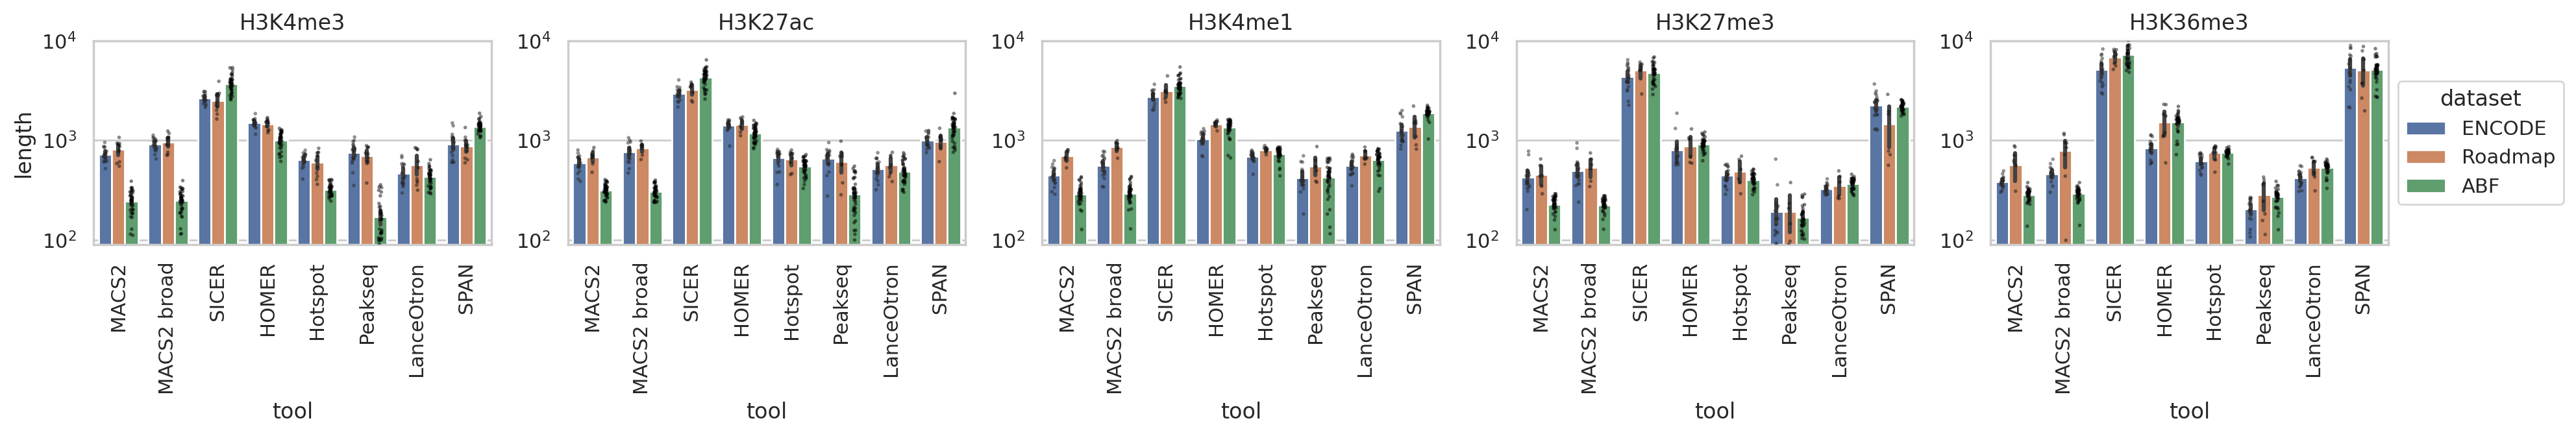

In [18]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.barplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.stripplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.5, legend=False,
                  order=TOOLS,
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  ax=ax)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(bottom=90, top=1e4)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


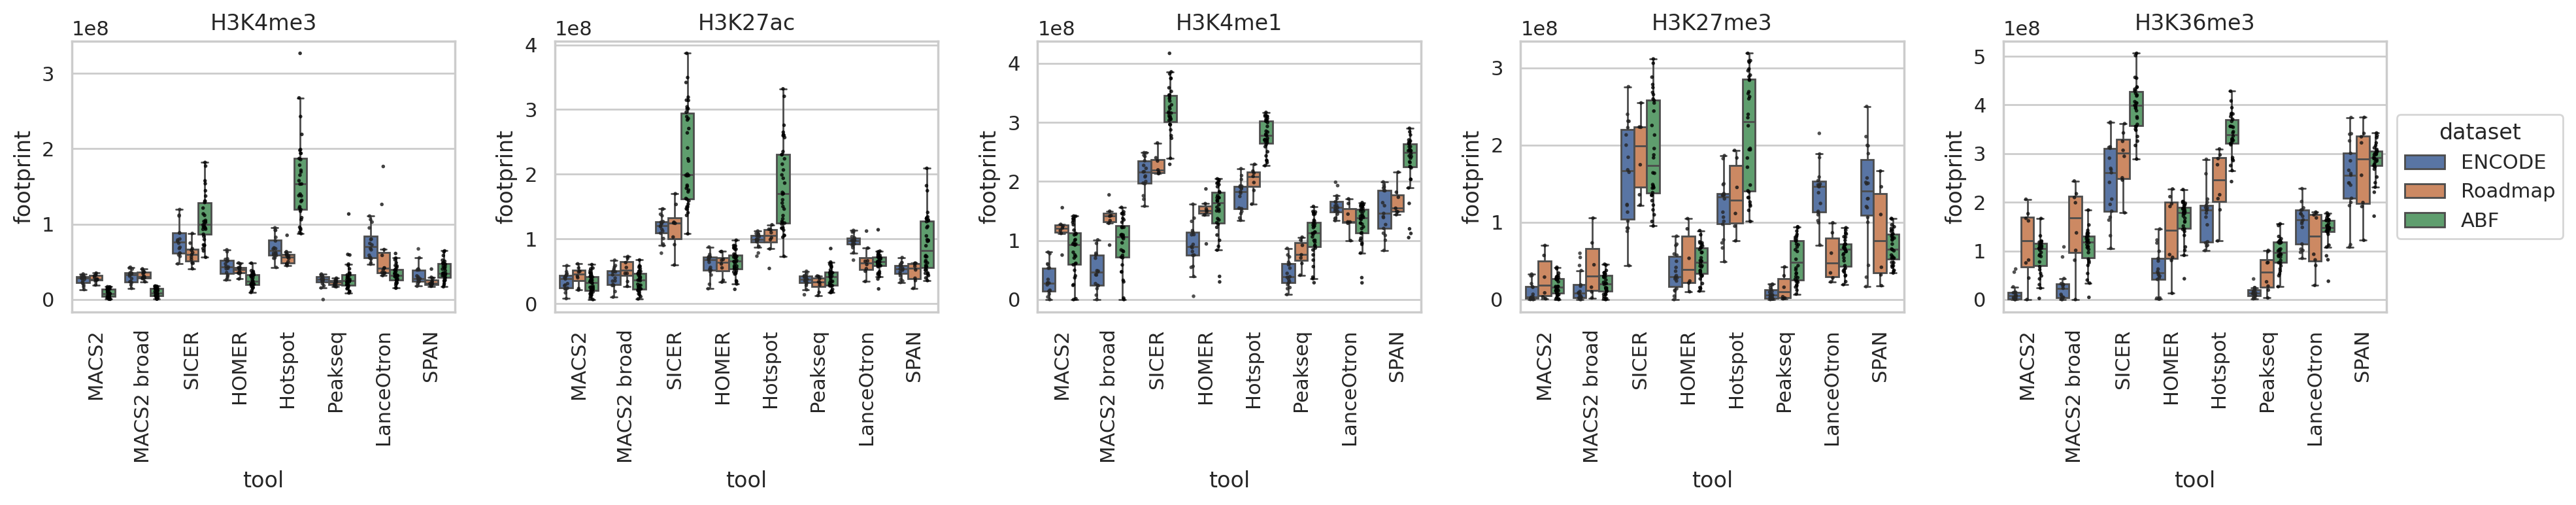

In [19]:
plt.figure(figsize=(20, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='footprint', hue='dataset',
                showfliers=False,
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.stripplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='footprint', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.8, legend=False,
                  order=TOOLS,
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  ax=ax)
    ax.title.set_text(m)

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Distance between peaks

In [20]:
print('Load distances')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(list(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
))):
    try:
        tf = pd.read_csv(file, sep='\t', header=None).sort_values(by=[0, 1, 2])
        tss = []
        for chr, tfc in tf.groupby(0):
            starts = tfc[1]
            ends = tfc[2]
            ends = np.roll(ends, 1)
            ds = starts - ends
            t = pd.DataFrame(dict(distance=ds))
            # Ignore first and last
            tss.append(t.iloc[1:min(1_000, len(t) - 1)])
        t = pd.concat(tss).reset_index(drop=True)
        t['dataset'] = dataset
        t['modification'] = mod
        t['cell'] = cell
        t['replicate'] = rep
        t['tool'] = tool
        ts.append(t)
    except:
        pass
df_distances = pd.concat(ts).reset_index(drop=True)
del ts, tss, t
df_distances.sample(10)

Load distances


  0%|          | 0/2320 [00:00<?, ?it/s]

distance  dataset modification  cell replicate        tool
49288888      1999      ABF      H3K4me3    OD       OD3  LanceOtron
40332021      7310      ABF      H3K4me3    OD      OD10     Hotspot
28363489     10601      ABF      H3K4me1    YD       YD7       SICER
7415470     135453   ENCODE      H3K4me1    H1      rep2       HOMER
37702038      1077      ABF      H3K4me1    OD       OD8       HOMER
35330024       824      ABF      H3K4me1    YD      YD20       HOMER
13853744       248  Roadmap      H3K27ac   CD4      rep1       MACS2
11263985     43141   ENCODE      H3K4me3  HSMM      rep2     Peakseq
29666999      7601      ABF      H3K4me1    YD      YD20       SICER
11921370       475   ENCODE     H3K27me3  HMEC      rep1  LanceOtron

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


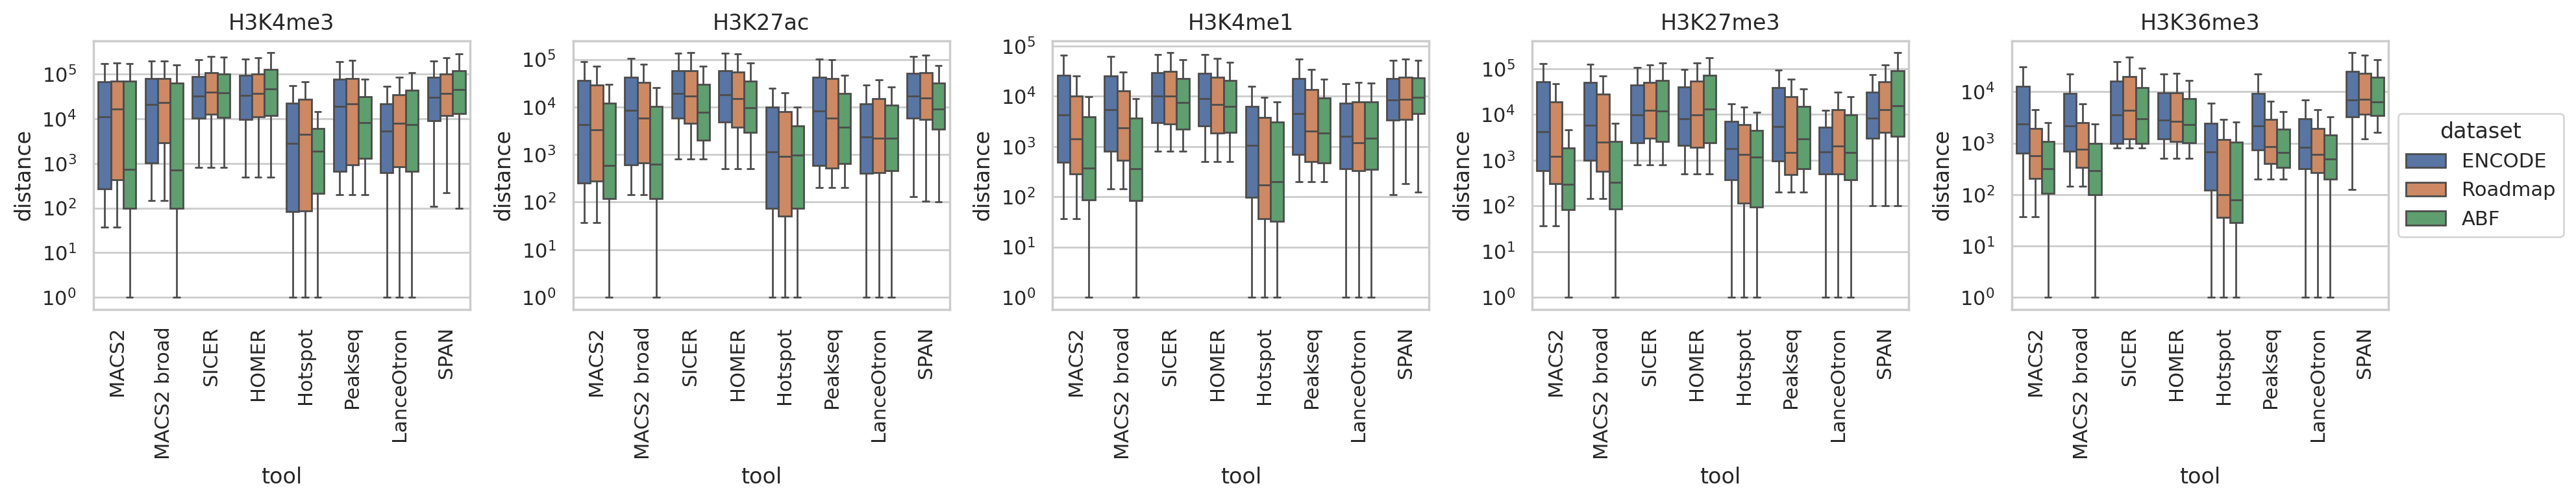

In [21]:
plt.figure(figsize=(20, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_distances[df_distances['modification'] == m],
                x='tool', y='distance', hue='dataset',
                showfliers=False,
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Average distance

In [22]:
# Keep % of peaks, since outliers may significantly shift results
ts = []
for (ds, m, c, r, tool), dft in df_distances[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'distance']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']):
    dft.sort_values(by=['distance'], inplace=True)
    ts.append(dft.iloc[int(len(dft) * 0.1): int(len(dft) * 0.9)])
    # ts.append(dft)
ts = pd.concat(ts).reset_index(drop=True)
df_distances_avg = ts.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
df_distances_avg['ds_c_r'] = df_distances_avg['dataset'] + ' ' + df_distances_avg['cell'] + ' ' + df_distances_avg[
    'replicate']
df_distances_avg.sample(3)

dataset modification   cell replicate   tool       distance  \
2108  Roadmap     H3K36me3  BCell            SICER   11077.671004   
1382   ENCODE      H3K27ac  HepG2      rep2  HOMER   78724.454672   
2073  Roadmap     H3K27me3    CD4            MACS2  314709.610885   

                 ds_c_r  
2108     Roadmap BCell   
1382  ENCODE HepG2 rep2  
2073       Roadmap CD4

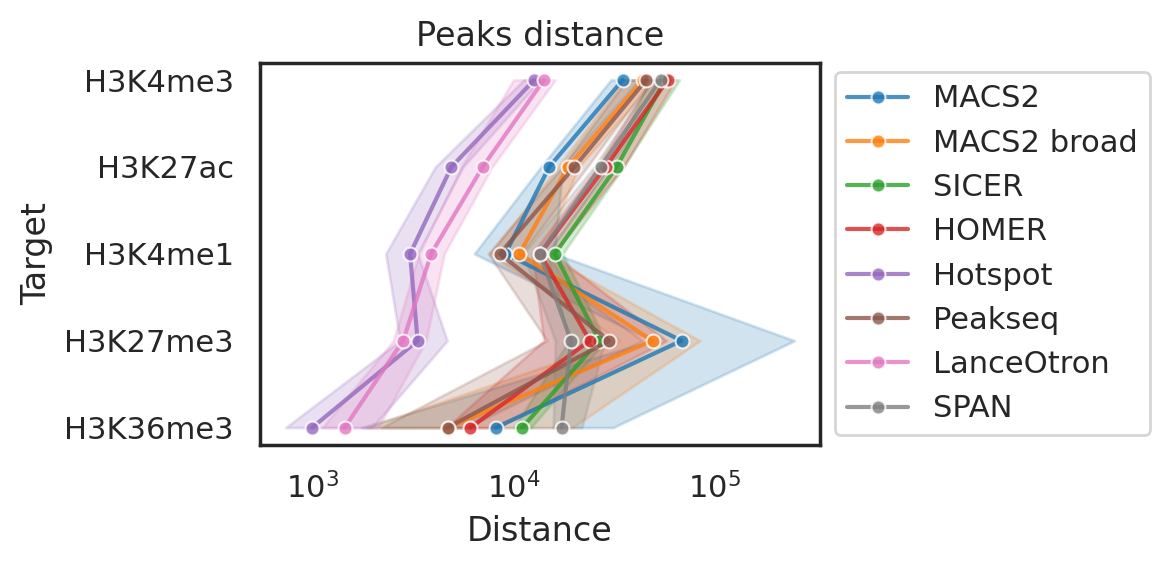

In [23]:
sns.set_theme(style="white")
df_lens['mindex'] = 0
for i, m in enumerate(reversed(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])):
    df_distances_avg.loc[df_distances_avg['modification'] == m, 'mindex'] = i
plt.figure(figsize=(6, 3))
t = df_distances_avg[df_distances_avg['dataset'].isin(['ENCODE', 'Roadmap', ])]
g_results = sns.lineplot(data=t.sort_values(by=['mindex', 'tool', 'distance']),
                         x='distance', y='mindex', hue='tool', orient='y', estimator='median',
                         alpha=0.8,
                         hue_order=TOOLS,
                         palette=TOOLS_PALETTE,
                         marker='o', markersize=5
                         )
g_results.axes.set_yticks(range(5), minor=False)
g_results.axes.set_yticklabels(reversed(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']))
g_results.axes.set_ylabel('Target')
g_results.axes.set_xlabel('Distance')
g_results.set(xscale='log')
g_results.axes.title.set_text(f'Peaks distance')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
sns.set_theme(style="whitegrid")

# Avg length vs distance

ENCODE + Roadmap


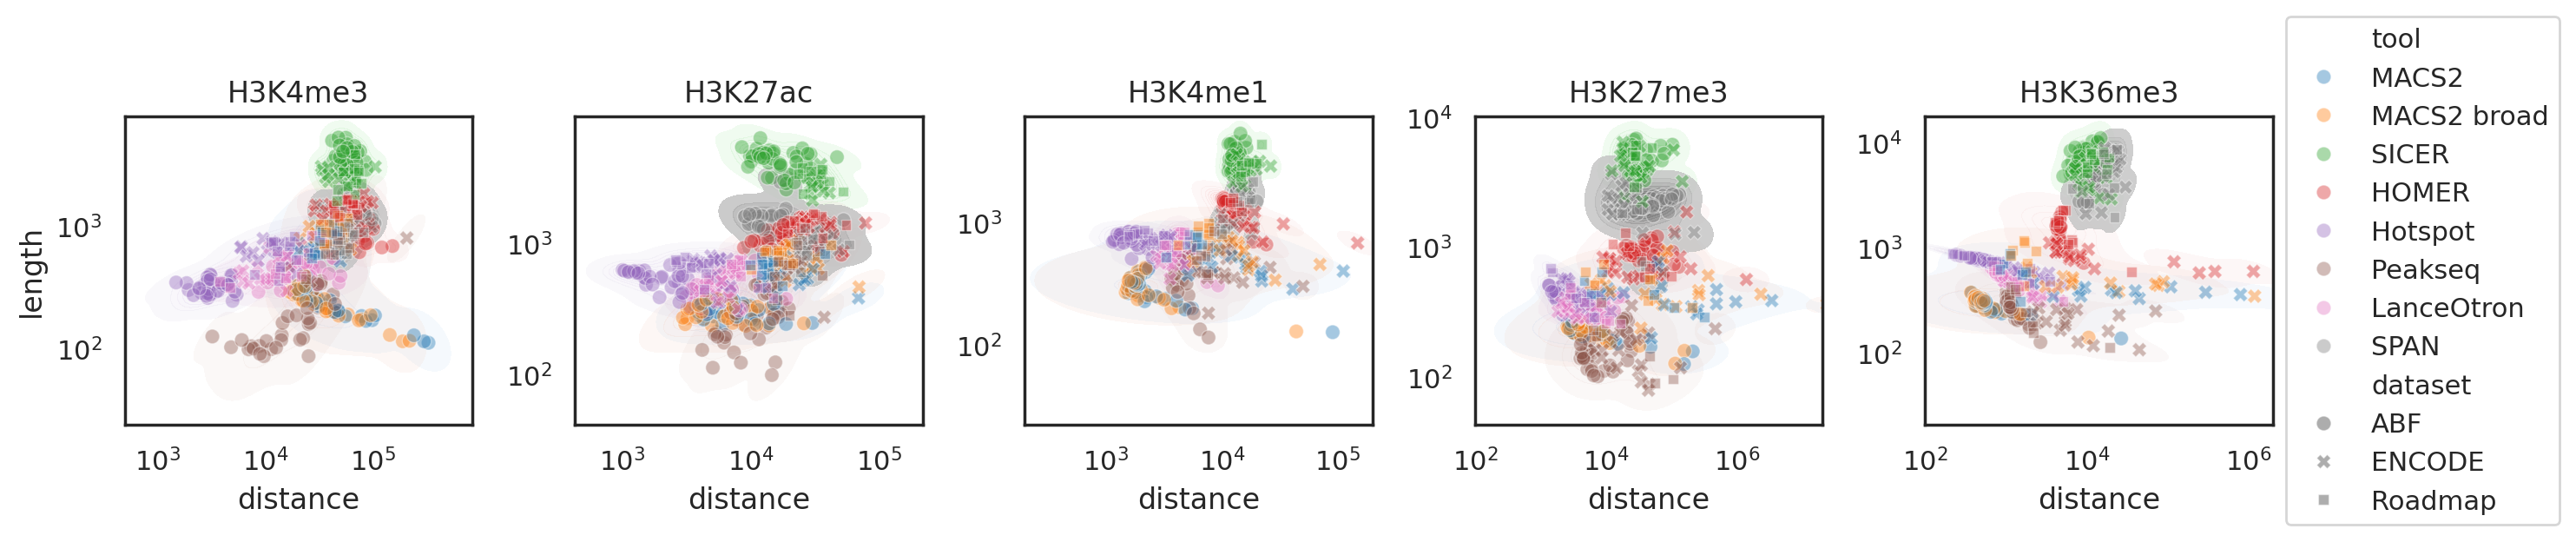

In [24]:
print('ENCODE + Roadmap')
sns.set_theme(style="white")
t = pd.merge(df_lens_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'length']],
             df_distances_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'distance']],
             on=['dataset', 'modification', 'cell', 'replicate', 'tool'])

plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    tm = t[(t['modification'] == m)]
    sns.kdeplot(
        tm[tm['tool'] != 'SPAN'], x='distance', y='length', hue='tool',
        alpha=0.1,
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        thresh=0.01,
        log_scale=True,
        fill=True,
        legend=False,
        ax=ax)
    sns.kdeplot(
        tm[tm['tool'] == 'SPAN'], x='distance', y='length', hue='tool',
        alpha=0.8,
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        thresh=0.01,
        log_scale=True,
        fill=True,
        legend=False,
        ax=ax)
    sns.scatterplot(tm,
                    palette=TOOLS_PALETTE,
                    hue_order=TOOLS,
                    style='dataset',
                    x='distance', y='length', hue='tool', alpha=0.4,
                    ax=ax)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(xscale='log')
    ax.set(yscale='log')
    if m == 'H3K4me1':
        ax.set_xlim(2e2, 2e5)
    if m == 'H3K27me3':
        ax.set_xlim(1e2, 2e7)
    if m == 'H3K36me3':
        ax.set_xlim(1e2, 2e6)
plt.tight_layout()
plt.show()
sns.set_theme(style="whitegrid")

# ATAC-seq, CTCF info



In [27]:
def simple_load_peaks(path, suffix):
    df = pd.DataFrame(columns=['file', 'peaks'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        file = os.path.join(path, f)
        ps = lines(file)
        df.loc[len(df)] = (file, ps)
    return df


def simple_load_peaks_path(path):
    df_macs2 = simple_load_peaks(os.path.join(path, 'macs2'), '.narrowPeak')
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2_broad = simple_load_peaks(os.path.join(path, 'macs2'), '.broadPeak')
    df_macs2_broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2_broad))

    df_sicer = simple_load_peaks(os.path.join(path, 'sicer'), '.scoreisland')
    if len(df_sicer) == 0:
        df_sicer = simple_load_peaks(os.path.join(path, 'sicer'), '-FDR0.01')
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = simple_load_peaks(os.path.join(path, 'span'), '.peak')
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    df_homer = simple_load_peaks(os.path.join(path, 'homer'), '.peaks')
    df_homer['tool'] = 'HOMER'
    print('HOMER', len(df_homer))

    df_hotspot = simple_load_peaks(os.path.join(path, 'hotspot'), '.peak')
    df_hotspot['tool'] = 'Hotspot'
    print('Hotspot', len(df_hotspot))

    df_peakseq = simple_load_peaks(os.path.join(path, 'peakseq'), '.narrowPeak')
    df_peakseq['tool'] = 'Peakseq'
    print('Peakseq', len(df_peakseq))

    df_lanceotron = simple_load_peaks(os.path.join(path, 'lanceotron'), '.bed')
    df_lanceotron['tool'] = 'LanceOtron'
    print('LanceOtron', len(df_lanceotron))

    return pd.concat([df_macs2, df_macs2_broad, df_sicer, df_span, df_homer, df_hotspot, df_peakseq, df_lanceotron]).reset_index(
        drop=True)

In [30]:
ATAC_PATH = os.path.expanduser('~/data/2024_Immgen')
dfa = simple_load_peaks_path(ATAC_PATH)
dfa

  0%|          | 0/1480 [00:00<?, ?it/s]

MACS2 185


  0%|          | 0/1480 [00:00<?, ?it/s]

MACS2 broad 185


  0%|          | 0/185 [00:00<?, ?it/s]

SICER 185


  0%|          | 0/2220 [00:00<?, ?it/s]

SPAN 185


  0%|          | 0/185 [00:00<?, ?it/s]

HOMER 185


  0%|          | 0/185 [00:00<?, ?it/s]

Hotspot 185


0it [00:00, ?it/s]

Peakseq 0


  0%|          | 0/22 [00:00<?, ?it/s]

LanceOtron 8


file   peaks        tool
0     /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   17421       MACS2
1     /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   64081       MACS2
2     /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   21233       MACS2
3     /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   29318       MACS2
4     /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   37337       MACS2
...                                                 ...     ...         ...
1113  /home/jetbrains/data/2024_Immgen/lanceotron/SR...  220693  LanceOtron
1114  /home/jetbrains/data/2024_Immgen/lanceotron/SR...  298283  LanceOtron
1115  /home/jetbrains/data/2024_Immgen/lanceotron/SR...  236537  LanceOtron
1116  /home/jetbrains/data/2024_Immgen/lanceotron/SR...  229109  LanceOtron
1117  /home/jetbrains/data/2024_Immgen/lanceotron/SR...  247071  LanceOtron

[1118 rows x 3 columns]

In [31]:
ts = []
for tool, file in tqdm(zip(dfa['tool'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t.sort_values(by=['length'], inplace=True)
    t = t.sample(min(len(t), 10_000)).copy()
    t = t.iloc[: int(len(t) * 0.9)].copy()  # ATAC-seq may include large domains, skip them
    t['tool'] = tool
    t['file'] = file
    ts.append(t)
dfa_lens = pd.concat(ts).reset_index(drop=True)
dfa_lens['modification'] = 'ATAC'
dfa_lens['dataset'] = 'Immgen'
dfa_lens_avg = dfa_lens.groupby(['dataset', 'modification', 'tool', 'file']).agg('mean').reset_index()
del ts
display(dfa_lens_avg.sample(10))

0it [00:00, ?it/s]

dataset modification         tool  \
902  Immgen         ATAC        SICER   
324  Immgen         ATAC      Hotspot   
403  Immgen         ATAC        MACS2   
636  Immgen         ATAC  MACS2 broad   
676  Immgen         ATAC  MACS2 broad   
454  Immgen         ATAC        MACS2   
983  Immgen         ATAC         SPAN   
538  Immgen         ATAC        MACS2   
527  Immgen         ATAC        MACS2   
53   Immgen         ATAC        HOMER   

                                                  file       length  
902  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  1581.977778  
324  /home/jetbrains/data/2024_Immgen/hotspot/SRR57...   388.808111  
403  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   165.276111  
636  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   212.685889  
676  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   226.961000  
454  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   180.695111  
983  /home/jetbrains/data/2024_Immgen/span/SRR57994...   474.686667  
538  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   182.083222  
527  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   169.379667  
53   /home/jetbrains/data/2024_Immgen/homer/SRR5799...   841.059222

In [32]:
CTCF_PATH = os.path.expanduser('~/data/2024_TFs')
df_ctcf = simple_load_peaks_path(CTCF_PATH)
display(df_ctcf)

  0%|          | 0/74 [00:00<?, ?it/s]

MACS2 9


  0%|          | 0/74 [00:00<?, ?it/s]

MACS2 broad 11


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

SICER 9


  0%|          | 0/117 [00:00<?, ?it/s]

SPAN 9


  0%|          | 0/9 [00:00<?, ?it/s]

HOMER 9


  0%|          | 0/9 [00:00<?, ?it/s]

Hotspot 9


  0%|          | 0/15 [00:00<?, ?it/s]

Peakseq 9


  0%|          | 0/18 [00:00<?, ?it/s]

LanceOtron 9


file   peaks        tool
0   /home/jetbrains/data/2024_TFs/macs2/Monocyte_C...   24810       MACS2
1   /home/jetbrains/data/2024_TFs/macs2/GM12878_re...   50063       MACS2
2   /home/jetbrains/data/2024_TFs/macs2/H1_CTCF_EN...   61358       MACS2
3   /home/jetbrains/data/2024_TFs/macs2/NHLF_CTCF_...   18950       MACS2
4   /home/jetbrains/data/2024_TFs/macs2/BCell_CTCF...   30160       MACS2
..                                                ...     ...         ...
69  /home/jetbrains/data/2024_TFs/lanceotron/K562_...  205646  LanceOtron
70  /home/jetbrains/data/2024_TFs/lanceotron/NK_CT...   35818  LanceOtron
71  /home/jetbrains/data/2024_TFs/lanceotron/Monoc...  284628  LanceOtron
72  /home/jetbrains/data/2024_TFs/lanceotron/HepG2...  134669  LanceOtron
73  /home/jetbrains/data/2024_TFs/lanceotron/BCell...   47600  LanceOtron

[74 rows x 3 columns]

In [33]:
ts = []
for tool, file in tqdm(zip(df_ctcf['tool'], df_ctcf['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['tool'] = tool
    t['file'] = file
    ts.append(t)
dfa_ctcf_lens = pd.concat(ts).reset_index(drop=True)
dfa_ctcf_lens['modification'] = 'CTCF'
dfa_ctcf_lens['dataset'] = 'CTCF'
dfa_ctcf_lens_avg = dfa_ctcf_lens.groupby(['dataset', 'modification', 'tool', 'file']).agg('mean').reset_index()
del ts
display(dfa_ctcf_lens_avg.sample(3))

0it [00:00, ?it/s]

dataset modification     tool  \
55    CTCF         CTCF    SICER   
17    CTCF         CTCF  Hotspot   
46    CTCF         CTCF  Peakseq   

                                                 file     length  
55  /home/jetbrains/data/2024_TFs/sicer/CD4_CTCF_E...  2406.1000  
17  /home/jetbrains/data/2024_TFs/hotspot/NK_CTCF_...   367.7131  
46  /home/jetbrains/data/2024_TFs/peakseq/CD4_CTCF...   496.1291

In [34]:
# Keep % of peaks, since outliers may significantly shift results
tracks_per_dataset = 20
ds_counter = Counter()
ts = []
for (ds, m, tool), dft in pd.concat([df_lens_avg, dfa_ctcf_lens_avg, dfa_lens_avg]).groupby(
        ['dataset', 'modification', 'tool']):
    c = ds_counter[(ds, m, tool)]
    if c >= tracks_per_dataset:
        continue
    ds_counter[(ds, m, tool)] += (tracks_per_dataset - c)
    ts.append(dft.head(tracks_per_dataset - c))

df_lens_balanced_avg = pd.concat(ts).reset_index()
display(df_lens_balanced_avg.sample(3))
# ds_counter

index  dataset modification  cell replicate         tool      length  \
1816   2157  Roadmap     H3K36me3  PBMC                  MACS2  594.061875   
1496   1982   ENCODE      H3K4me3  NHEK      rep2  MACS2 broad  781.034875   
1627    576   Immgen         ATAC   NaN       NaN  MACS2 broad  228.510556   

       footprint            ds_c_r  \
1816  81252936.0     Roadmap PBMC    
1496  34418235.0  ENCODE NHEK rep2   
1627         NaN               NaN   

                                                   file  
1816                                                NaN  
1496                                                NaN  
1627  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...

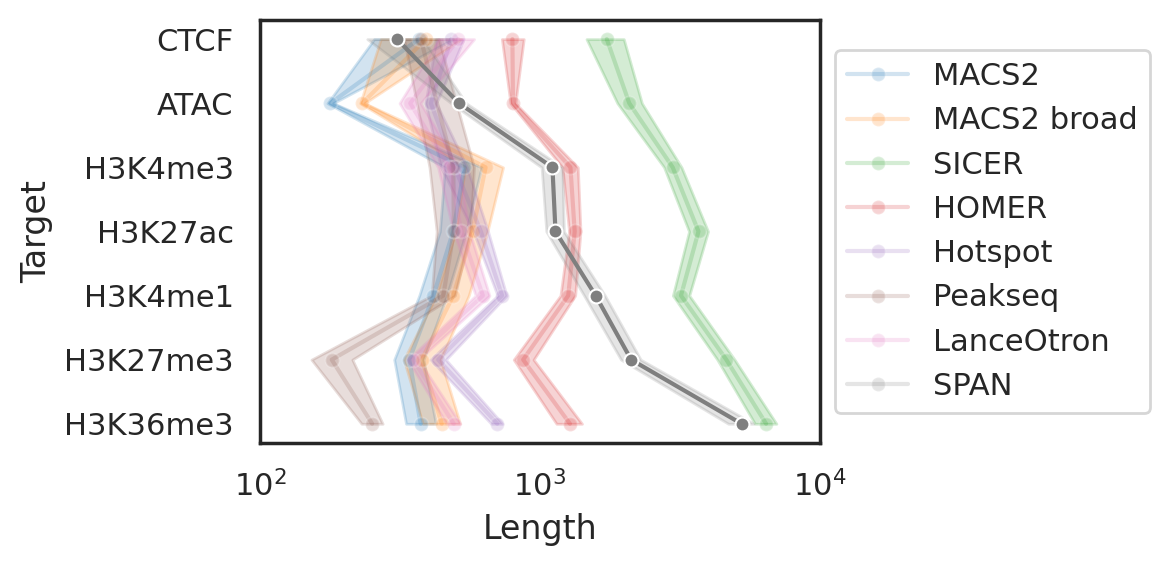

In [35]:
t = df_lens_balanced_avg.copy()

sns.set_theme(style="white")
t['mindex'] = 0
for i, m in enumerate(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])):
    t.loc[t['modification'] == m, 'mindex'] = i
t = t.sort_values(by=['mindex', 'tool', 'length'])
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.lineplot(data=t[t['tool'] != 'SPAN'],
             x='length', y='mindex', hue='tool', orient='y',
             alpha=0.2,
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             marker='o', markersize=5,
             ax=ax)
sns.lineplot(data=t[t['tool'] == 'SPAN'],
             x='length', y='mindex', hue='tool', orient='y',
             alpha=1.0,
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             marker='o', markersize=5,
             legend=False,
             ax=ax)
ax.set_yticks(range(7), minor=False)
ax.set_yticklabels(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']))
ax.set_ylabel('Target')
ax.set_xlabel('Length')
ax.set(xscale='log')
ax.set_xlim(100, 1.0e4)
ax.title.set_text(f'')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# BAMs

In [7]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if mod and cell is not None and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

In [11]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'

In [12]:
df_abf_bams = load_bams(ABF_PATH + '/bams', ABF_MODIFICATIONS, [''], ABF_REPLICATES, 'input')
update_abf_modifications(df_abf_bams)
df_abf_bams['dataset'] = 'ABF'
reads = ! samtools view -F 0x04 -c {ABF_PATH}/bams/input.bam
reads = int(reads[0])
df_abf_bams.loc[len(df_abf_bams)] = (f'{ABF_PATH}/bams/input.bam', 'Control', '', '', reads, 'ABF')

  0%|          | 0/384 [00:00<?, ?it/s]

In [16]:
def simple_load_bams(path):
    df_bams = pd.DataFrame(columns=['bam_file', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        file = os.path.join(path, f)
        reads = ! samtools view -F 0x04 -c {file}
        reads = int(reads[0])
        df_bams.loc[len(df_bams)] = (file, reads)
    return df_bams


In [17]:
ATAC_PATH = os.path.expanduser('~/data/2024_Immgen')
df_atac_reads = simple_load_bams(ATAC_PATH + '/bams')
df_atac_reads['dataset'] = 'Immgen'
df_atac_reads['modification'] = 'ATAC'
df_atac_reads.sample(3)

  0%|          | 0/185 [00:00<?, ?it/s]

bam_file     reads dataset  \
117  /home/jetbrains/data/2024_Immgen/bams/SRR57995...  19686597  Immgen   
31   /home/jetbrains/data/2024_Immgen/bams/SRR57995...  19603986  Immgen   
111  /home/jetbrains/data/2024_Immgen/bams/SRR57995...  16916278  Immgen   

    modification  
117         ATAC  
31          ATAC  
111         ATAC

In [18]:
CTCF_PATH = os.path.expanduser('~/data/2024_TFs')
df_ctcf_reads = simple_load_bams(CTCF_PATH + '/bams')
df_ctcf_reads['dataset'] = 'ENCODE'
df_ctcf_reads['modification'] = 'CTCF'
df_ctcf_reads.sample(3)

  0%|          | 0/18 [00:00<?, ?it/s]

bam_file     reads dataset  \
0  /home/jetbrains/data/2024_TFs/bams/Monocyte_Co...  20067734  ENCODE   
8  /home/jetbrains/data/2024_TFs/bams/NK_Control_...  24502572  ENCODE   
7  /home/jetbrains/data/2024_TFs/bams/HepG2_rep1_...  19578862  ENCODE   

  modification  
0         CTCF  
8         CTCF  
7         CTCF

In [45]:
df_abf_bams['cell'] = ['OD' if r.startswith('OD') else 'YD' for r in df_abf_bams['replicate']]

In [46]:
df_bams_all = pd.concat([df_encode_bams, df_immune_bams, df_abf_bams, df_atac_reads, df_ctcf_reads]).reset_index(
    drop=True)
df_bams_all.sort_values(by=['dataset', 'modification'], inplace=True)

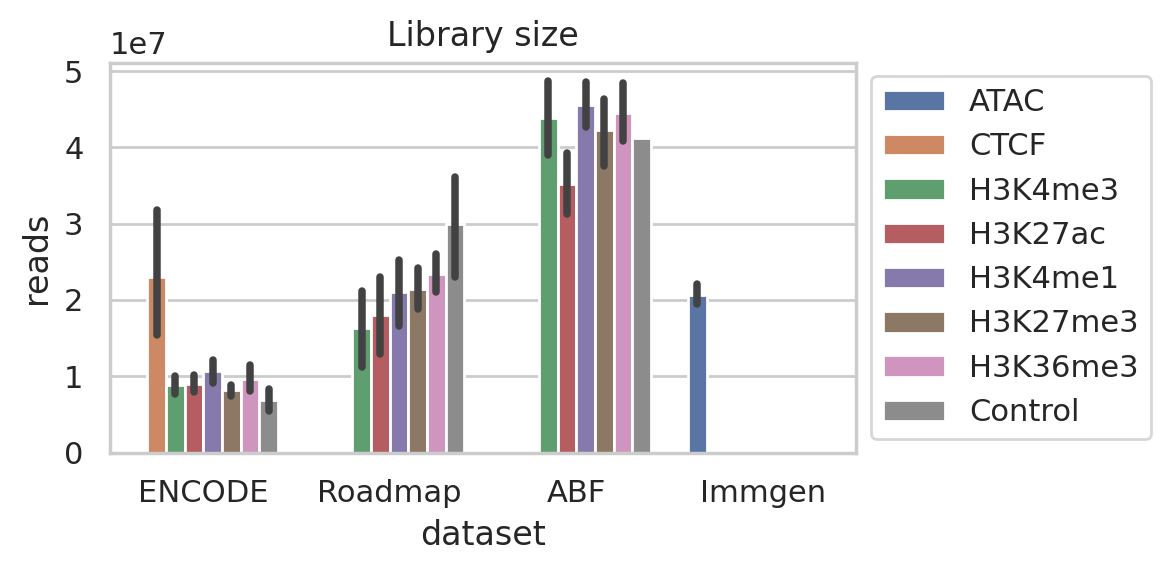

In [47]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_bams_all, hue='modification', x='dataset', y='reads',
            order=['ENCODE', 'Roadmap', 'ABF', 'Immgen'],
            # capsize=.05, err_kws={'linewidth': 2}, edgecolor="black",
            hue_order=['ATAC', 'CTCF'] + MODIFICATIONS + ['Control'],
            ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [48]:
def file_to_name(file):
    return re.sub('(.*SRR[0-9]+_)|(_ATAC_seq.*)', '', os.path.basename(file))


def file_to_srr(file):
    return re.sub('_.*', '', os.path.basename(file))


df_atac_reads['cell'] = [file_to_name(f) for f in df_atac_reads['bam_file']]
df_atac_reads['srr'] = [file_to_srr(f) for f in df_atac_reads['bam_file']]

In [49]:
df_counts = df_bams_all[df_bams_all['modification'] != 'Control'].groupby(
    ['dataset', 'modification']).size().reset_index(name='counts')
df_counts

dataset modification  counts
0       ABF      H3K27ac      40
1       ABF     H3K27me3      40
2       ABF     H3K36me3      39
3       ABF      H3K4me1      32
4       ABF      H3K4me3      40
5    ENCODE         CTCF      18
6    ENCODE      H3K27ac      17
7    ENCODE     H3K27me3      18
8    ENCODE     H3K36me3      17
9    ENCODE      H3K4me1      17
10   ENCODE      H3K4me3      16
11   Immgen         ATAC     185
12  Roadmap      H3K27ac       9
13  Roadmap     H3K27me3       9
14  Roadmap     H3K36me3       8
15  Roadmap      H3K4me1       8
16  Roadmap      H3K4me3      12

In [ ]:
sns.set_style('whitegrid')
for i, m in enumerate(MODIFICATIONS):
    dfm = df_peaks[df_peaks['modification'] == m]
    # Set up the matplotlib figure with broken y-axis
    f, (axt, ax) = plt.subplots(2, 1, sharex=True, figsize=(4, 3.5),
                                gridspec_kw={'height_ratios': [1, 2]})
    for j, axes in enumerate([ax, axt]):
        sns.barplot(data=dfm, x='tool', y='peaks', hue='dataset',
                    order=TOOLS,
                    hue_order=['ENCODE', 'Roadmap', 'ABF'],
                    ax=axes)
        sns.stripplot(data=dfm, x='tool', y='peaks', hue='dataset',
                      dodge=True, size=2, palette='dark:black', alpha=0.5,
                      order=TOOLS,
                      hue_order=['ENCODE', 'Roadmap', 'ABF'],
                      legend=False,
                      ax=axes)
    if m == 'H3K4me3':
        ax.set_ylim(bottom=0, top=50_000)
        axt.set_ylim(bottom=50_000, top=700_000)
    elif m == 'H3K27ac':
        ax.set_ylim(bottom=0, top=80_000)
        axt.set_ylim(bottom=80_000, top=650_000)
    elif m == 'H3K4me1':
        ax.set_ylim(bottom=0, top=120_000)
        axt.set_ylim(bottom=120_000, top=650_000)
    elif m == 'H3K27me3':
        ax.set_ylim(bottom=0, top=80_000)
        axt.set_ylim(bottom=80_000, top=650_000)
    elif m == 'H3K36me3':
        ax.set_ylim(bottom=0, top=75_000)
        axt.set_ylim(bottom=75_000, top=650_000)

    axt.set_xlabel(None)
    axt.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)
    axt.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    axt.legend().set_visible(False)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    # plt.tight_layout()
    plt.subplots_adjust(hspace=0.02)  # Adjust hspace closer to zero to remove spacing
    plt.show()

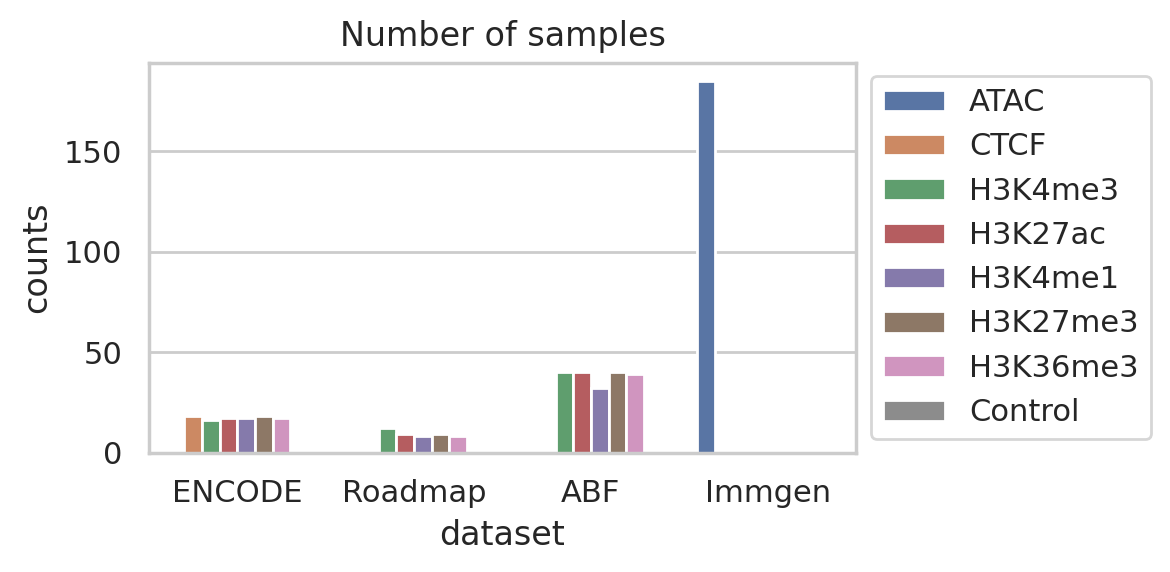

In [50]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_counts, hue='modification', x='dataset', y='counts',
            order=['ENCODE', 'Roadmap', 'ABF', 'Immgen'],
            hue_order=['ATAC', 'CTCF'] + MODIFICATIONS + ['Control'],
            ax=ax)
ax.set_title('Number of samples')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

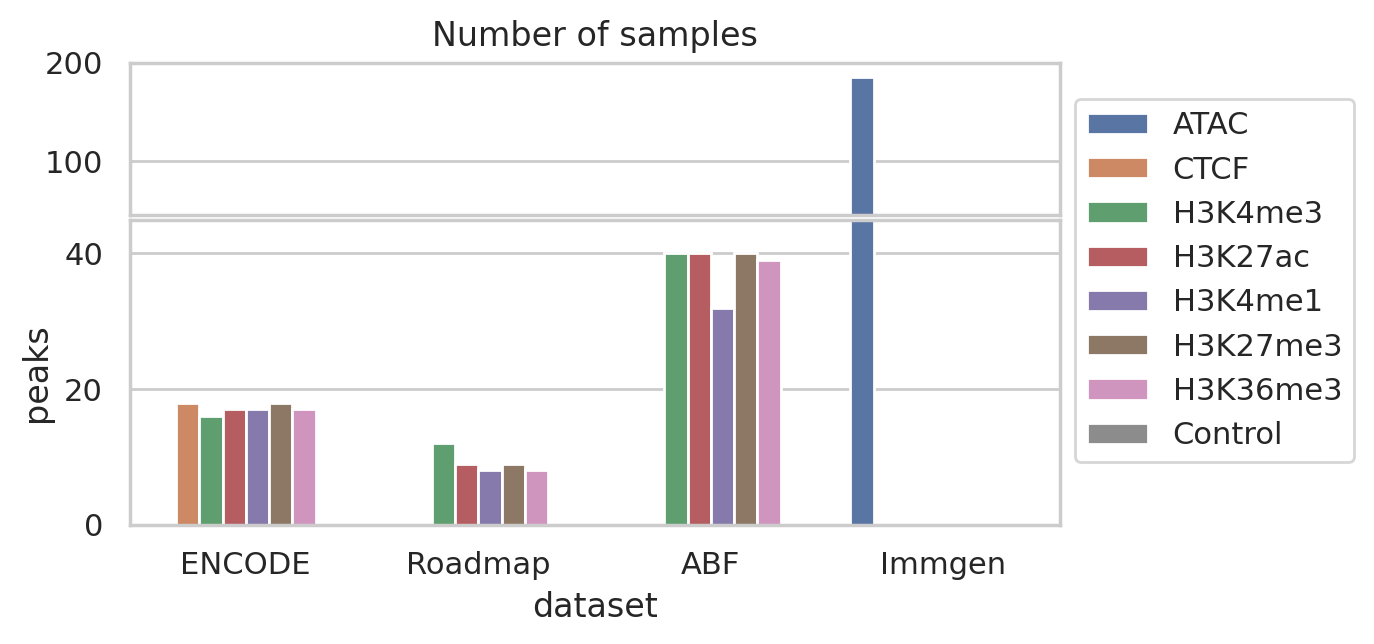

In [141]:
# Set up the matplotlib figure with broken y-axis
f, (axt, ax) = plt.subplots(2, 1, sharex=True, figsize=(6, 3),
                            gridspec_kw={'height_ratios': [1, 2]})
for axes in [ax, axt]:
    sns.barplot(data=df_counts, hue='modification', x='dataset', y='counts',
            order=['ENCODE', 'Roadmap', 'ABF', 'Immgen'],
            hue_order=['ATAC', 'CTCF'] + MODIFICATIONS + ['Control'],
            ax=axes)
ax.set_ylim(bottom=0, top=45)
axt.set_ylim(bottom=45, top=200)
axt.set_xlabel(None)
axt.set_ylabel(None)
axt.title.set_text('Number of samples')
ax.set_ylabel('peaks')
axt.legend().set_visible(False)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.02)  # Adjust hspace closer to zero to remove spacing
plt.show()

In [51]:
df_replicates_counts = df_bams_all[df_bams_all['modification'] != 'Control'].groupby(
    ['dataset', 'modification', 'cell']).size().reset_index(name='replicates')
df_replicates_counts

dataset modification      cell  replicates
0        ABF      H3K27ac        OD          20
1        ABF      H3K27ac        YD          20
2        ABF     H3K27me3        OD          20
3        ABF     H3K27me3        YD          20
4        ABF     H3K36me3        OD          20
..       ...          ...       ...         ...
121  Roadmap      H3K4me3  Monocyte           1
122  Roadmap      H3K4me3        NK           1
123  Roadmap      H3K4me3      PBMC           1
124  Roadmap      H3K4me3     TCell           1
125  Roadmap      H3K4me3   TCellBB           2

[126 rows x 4 columns]

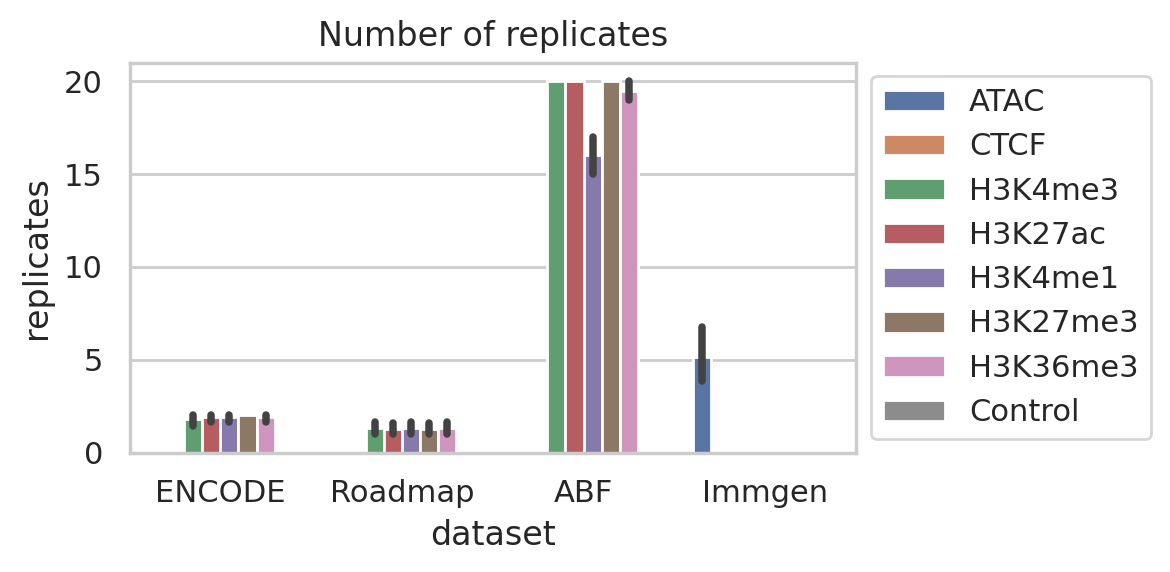

In [52]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_replicates_counts, hue='modification', x='dataset', y='replicates',
            order=['ENCODE', 'Roadmap', 'ABF', 'Immgen'],
            hue_order=['ATAC', 'CTCF'] + MODIFICATIONS + ['Control'],
            ax=ax)
ax.set_title('Number of replicates')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

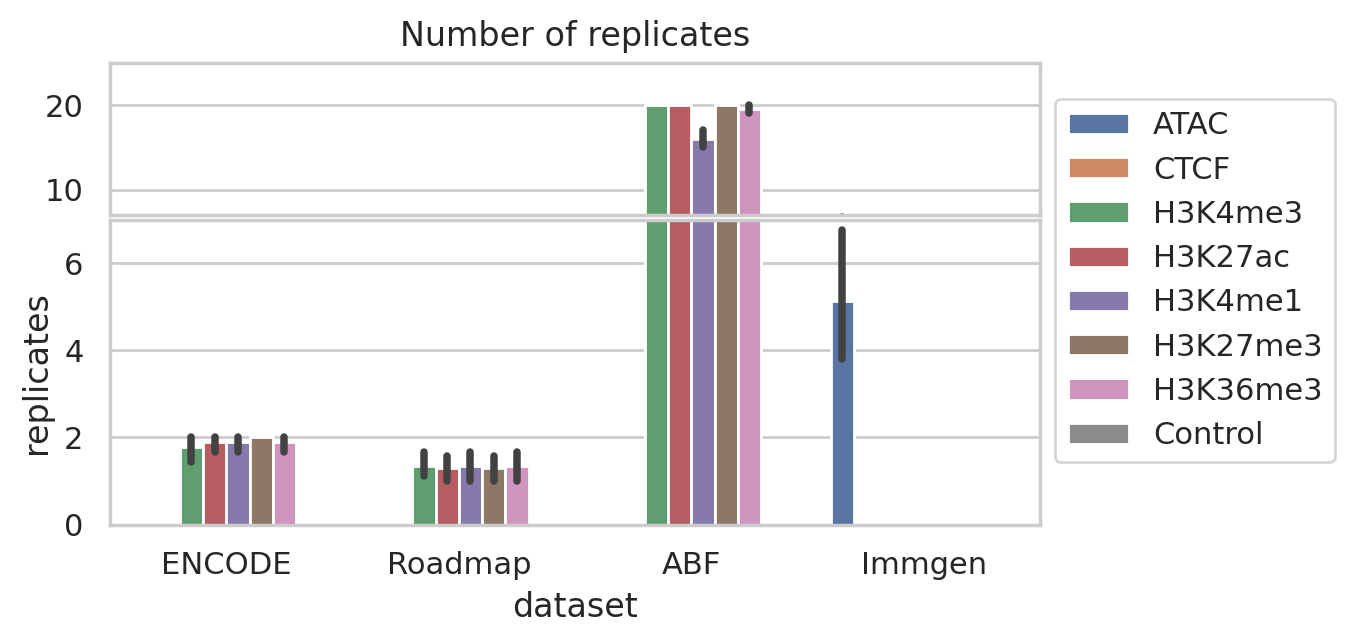

In [147]:
# Set up the matplotlib figure with broken y-axis
f, (axt, ax) = plt.subplots(2, 1, sharex=True, figsize=(6, 3),
                            gridspec_kw={'height_ratios': [1, 2]})
for axes in [ax, axt]:
    sns.barplot(data=df_replicates_counts, hue='modification', x='dataset', y='replicates',
                order=['ENCODE', 'Roadmap', 'ABF', 'Immgen'],
                hue_order=['ATAC', 'CTCF'] + MODIFICATIONS + ['Control'],
                ax=axes)
ax.set_ylim(bottom=0, top=7)
axt.set_ylim(bottom=7, top=25)
axt.set_xlabel(None)
axt.set_ylabel(None)
axt.title.set_text('Number of replicates')
ax.set_ylabel('replicates')
axt.legend().set_visible(False)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.02)  # Adjust hspace closer to zero to remove spacing
plt.show()

# Reads vs peaks

In [43]:
df_peaks_lens = pd.merge(df_peaks[['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
                         df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
                         on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_peaks_lens = pd.merge(df_peaks_lens,
                         df_lens_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']],
                         on=['dataset', 'modification', 'cell', 'replicate', 'tool'], how='inner')
df_peaks_lens.sample(3)

dataset modification  cell replicate         tool   peaks     reads  \
484  Roadmap      H3K4me3  CD34      rep2         SPAN   19154  13539143   
176   ENCODE      H3K27ac  K562      rep2        SICER   26159   6180094   
396  Roadmap      H3K4me1  CD34            MACS2 broad  140715  17619839   

          length    footprint  
484   904.477500   19271320.0  
176  2544.625000   78015441.0  
396   996.195625  177299718.0



peaks vs length


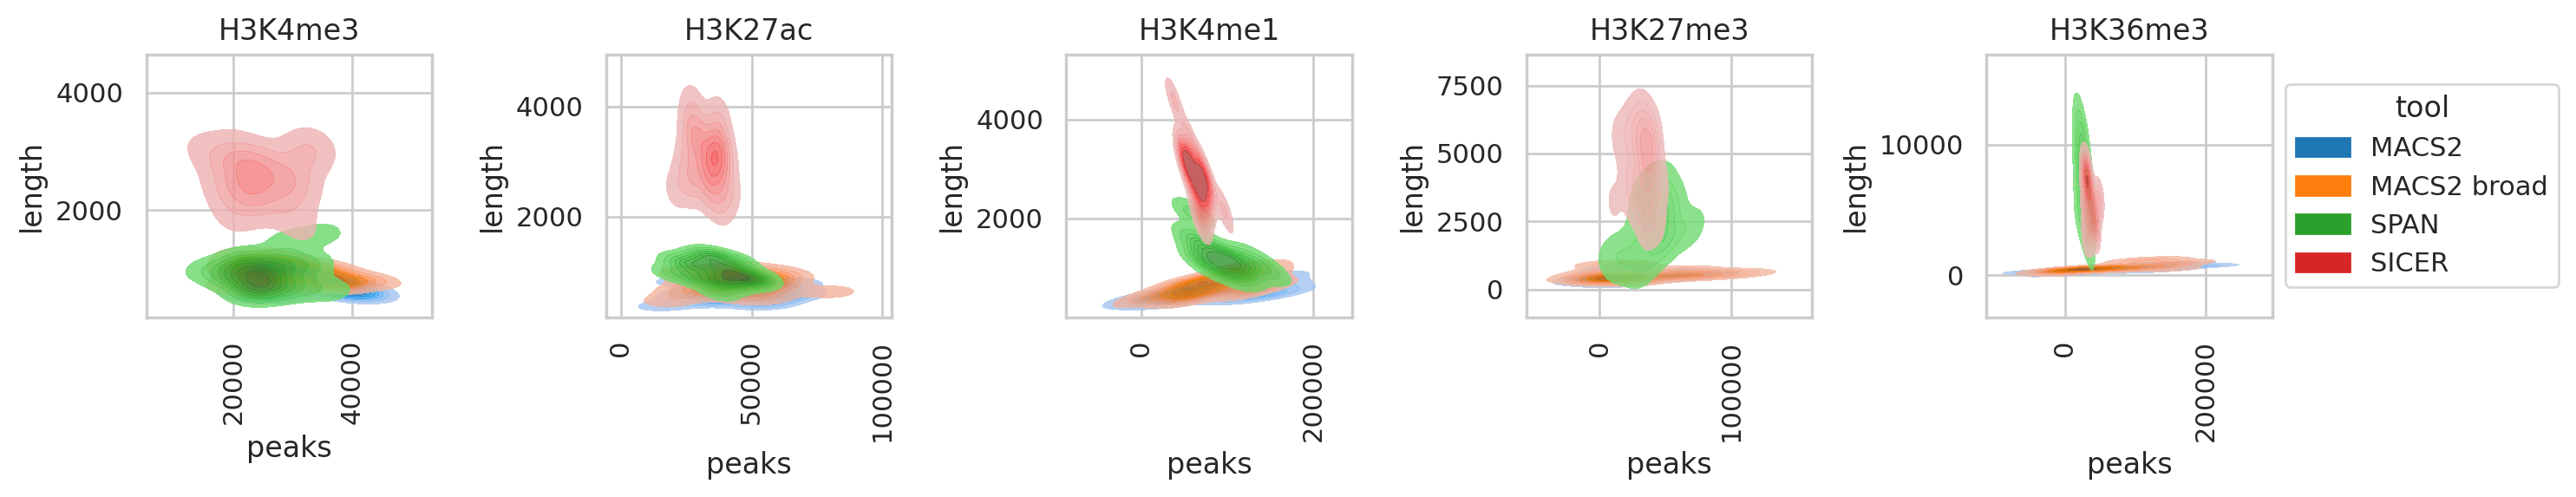



peaks vs reads


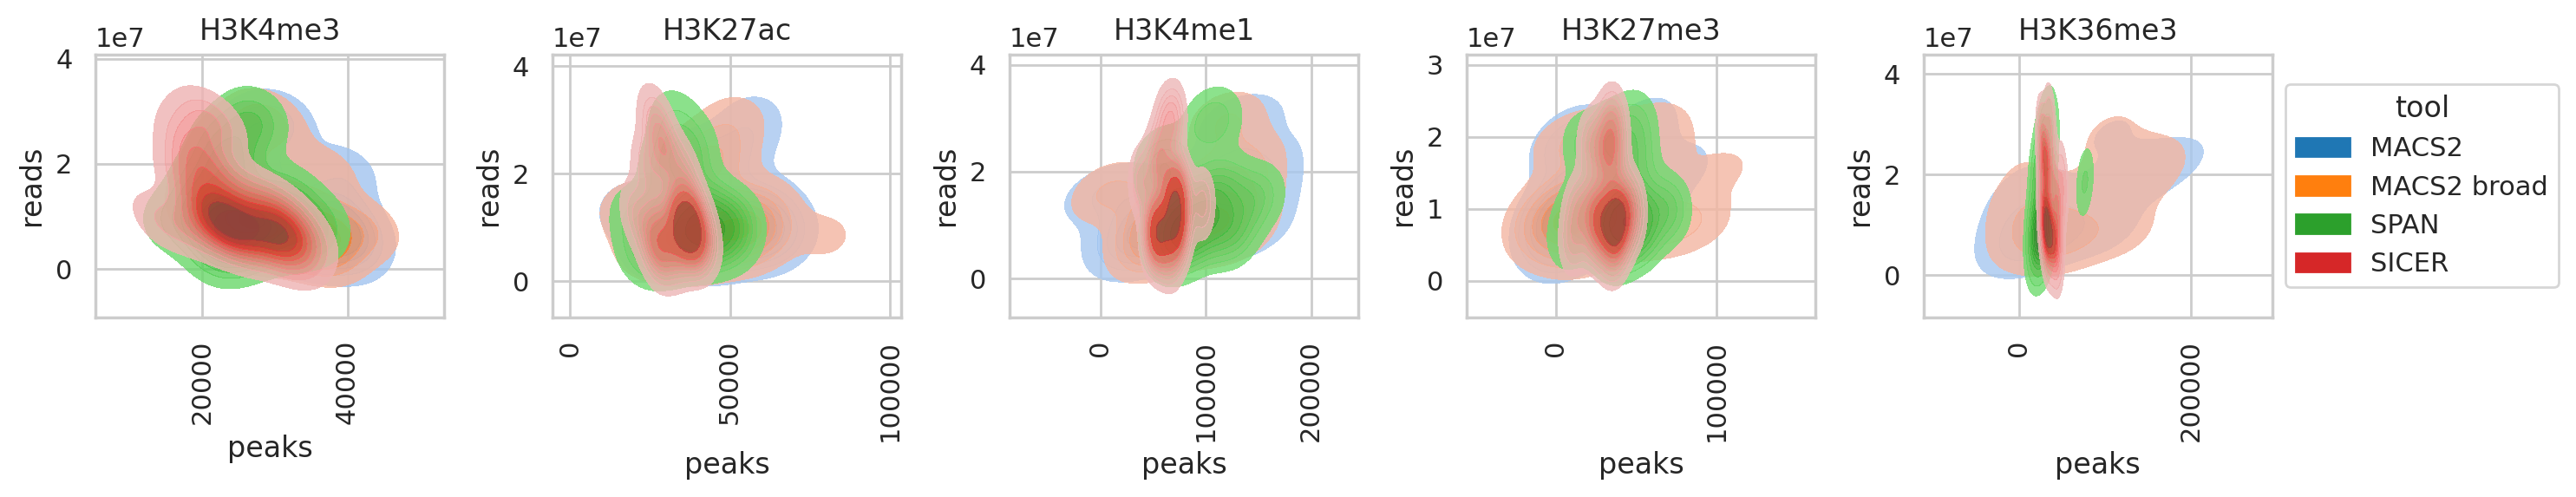

In [52]:
for x, y in [('peaks', 'length'), ('peaks', 'reads')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
        ax = axs[i]
        sns.kdeplot(
            df_peaks_lens[df_peaks_lens['modification'] == m], x=x, y=y, hue='tool',
            alpha=0.8,
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            thresh=0.05,
            fill=True,
            legend=i == len(axs) - 1,
            ax=ax)
        ax.title.set_text(m)
        if i == len(axs) - 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        if x != 'reads':
            ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

# Difference

In [45]:
def compute_diffs(diff_path, df):
    tools = df['tool'].unique()
    rows = []
    for (m, c, r), tmcr in tqdm(list(df.groupby(['modification', 'cell', 'replicate']))):
        print(m, c, r)
        t = tmcr[tmcr['tool'] == 'SPAN']
        if len(t) == 0:
            continue
        span_file = sorted_file(t['file'].values[0])
        # Processing single tools information
        for tool in tools:
            if tool == 'SPAN':
                continue
            t = tmcr[tmcr['tool'] == tool]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
                diff_file = f'{diff_path}/{name.replace(" ", "_")}_{m}_{c}_{r}.bed'
                ! bedtools intersect {args} -wa -v > {diff_file}
                peaks = lines(diff_file)
                rows.append((m, c, r, name, peaks))
    return pd.DataFrame(rows, columns=['modification', 'cell', 'replicate', 'name', 'peaks'])

In [46]:
def plot_diff(df_peaks, df_diff):
    t = df_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
    t.rename({'tool': 'name'}, axis=1, inplace=True)
    t = pd.concat([t, df_diff]).reset_index(drop=True)
    t = t.loc[
        [(m, c, r) not in OUTLIERS for _, (m, c, r) in t[['modification', 'cell', 'replicate']].iterrows()]].copy()

    plt.figure(figsize=(18, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        tm = t[t['modification'] == m]
        print(m, len(t))
        ax.set_title(m)
        sns.barplot(data=tm, x='name', y='peaks',
                    color='grey',
                    capsize=.2, err_kws={'linewidth': 2},
                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                           'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                           'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                           ],
                    ax=ax)
        sns.stripplot(data=tm, x='name', y='peaks',
                      size=2, alpha=0.8, color='black',
                      order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                             'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                             'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                             ],
                      legend=False,
                      ax=ax)
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_ylabel('Peaks number')
    plt.tight_layout()
    plt.show()

## ENCODE

In [53]:
dp = f'{GSE26320_PATH}/diff'
! mkdir -p {dp}
df_encode_diff = compute_diffs(dp, df_encode_peaks)
df_encode_diff.sample(5)

  0%|          | 0/85 [00:00<?, ?it/s]

H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac H1 rep1
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2
H3K27ac Huvec rep1
H3K27ac Huvec rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27me3 GM12878 rep1
H3K27me3 GM12878 rep2
H3K27me3 H1 rep1
H3K27me3 H1 rep2
H3K27me3 HMEC rep1
H3K27me3 HMEC rep2
H3K27me3 HSMM rep1
H3K27me3 HSMM rep2
H3K27me3 HepG2 rep1
H3K27me3 HepG2 rep2
H3K27me3 Huvec rep1
H3K27me3 Huvec rep2
H3K27me3 K562 rep1
H3K27me3 K562 rep2
H3K27me3 NHEK rep1
H3K27me3 NHEK rep2
H3K27me3 NHLF rep1
H3K27me3 NHLF rep2
H3K36me3 GM12878 rep1
H3K36me3 GM12878 rep2
H3K36me3 H1 rep1
H3K36me3 H1 rep2
H3K36me3 HMEC rep1
H3K36me3 HMEC rep2
H3K36me3 HSMM rep1
H3K36me3 HSMM rep2
H3K36me3 HepG2 rep1
H3K36me3 HepG2 rep2
H3K36me3 Huvec rep1
H3K36me3 Huvec rep2
H3K36me3 K562 rep1
H3K36me3 K562 rep2
H3K36me3 NHEK rep2
H3K36me3 NHLF rep1
H3K36me3 NHLF rep2
H3K4me1 G

modification   cell replicate                name  peaks
484      H3K4me3   K562      rep1        SPAN - SICER   2349
208     H3K27me3   NHLF      rep2        SPAN - SICER  15254
343      H3K4me1   HMEC      rep2        MACS2 - SPAN     40
51       H3K27ac  HepG2      rep2  MACS2 broad - SPAN    165
284     H3K36me3   K562      rep1  SPAN - MACS2 broad  15854

H3K4me3 850
H3K27ac 850
H3K4me1 850
H3K27me3 850
H3K36me3 850


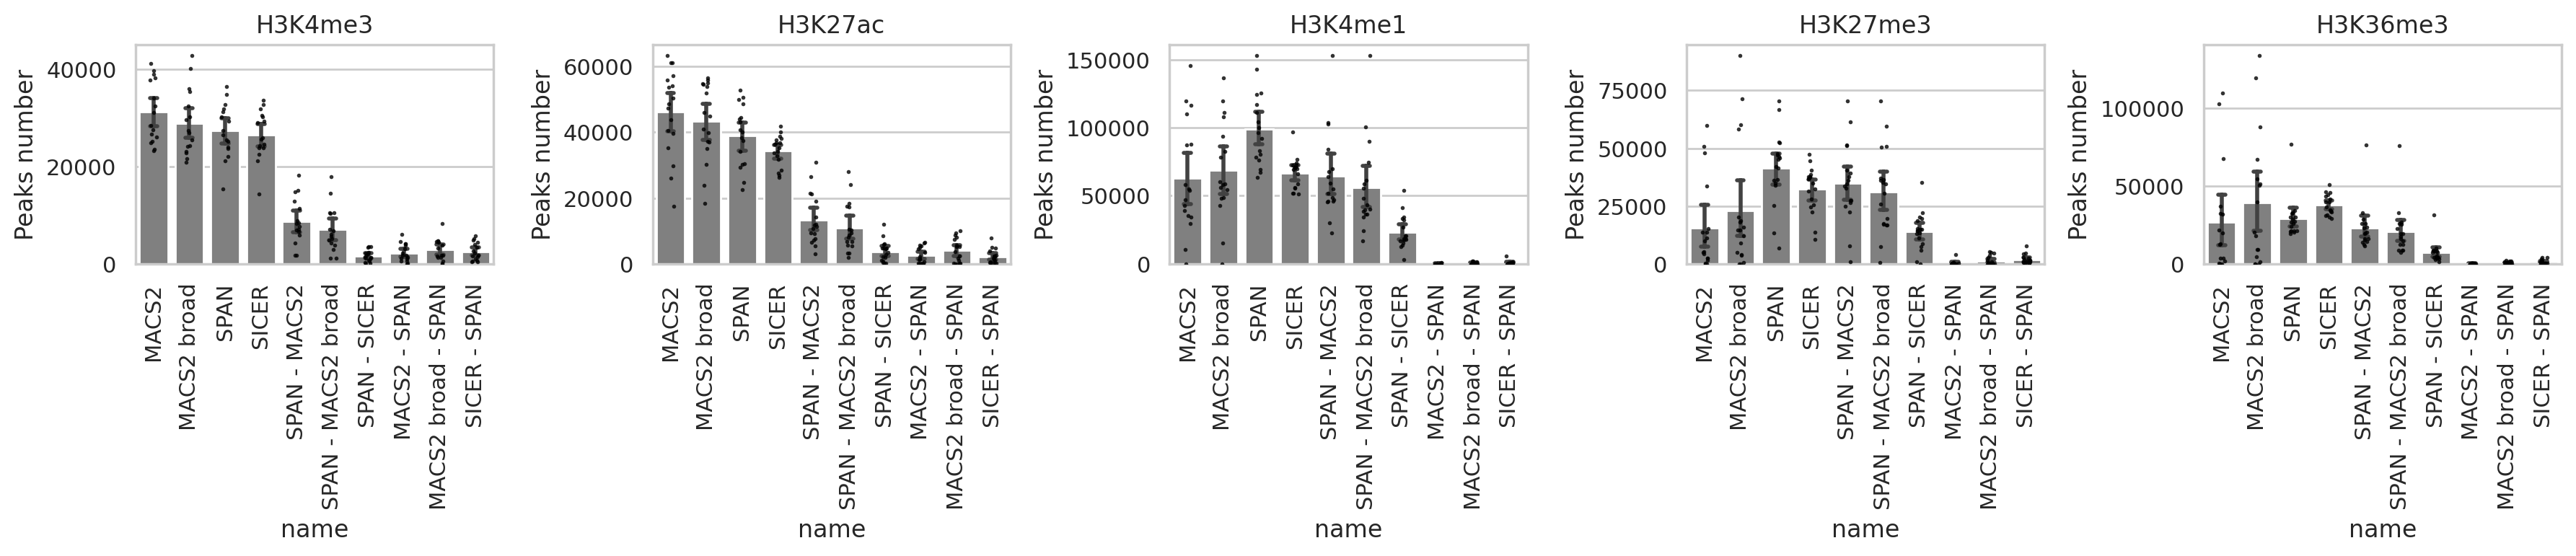

In [54]:
plot_diff(df_encode_peaks, df_encode_diff)

## Roadmap

In [55]:
dp = f'{IMMUNE_PATH}/diff'
! mkdir -p {dp}
df_immune_diff = compute_diffs(dp, df_immune_peaks)
df_immune_diff.sample(5)

  0%|          | 0/46 [00:00<?, ?it/s]

H3K27ac BCell 
H3K27ac CD34 
H3K27ac CD34 rep2
H3K27ac CD4 
H3K27ac CD4 rep1
H3K27ac Monocyte 
H3K27ac NK 
H3K27ac PBMC 
H3K27ac TCell 
H3K27me3 BCell 
H3K27me3 CD34 
H3K27me3 CD34 rep2
H3K27me3 CD4 
H3K27me3 CD4 rep2
H3K27me3 Monocyte 
H3K27me3 NK 
H3K27me3 PBMC 
H3K27me3 TCell 
H3K36me3 BCell 
H3K36me3 CD34 
H3K36me3 CD34 rep1
H3K36me3 CD4 
H3K36me3 CD4 rep1
H3K36me3 Monocyte 
H3K36me3 PBMC 
H3K36me3 TCell 
H3K4me1 BCell 
H3K4me1 CD34 
H3K4me1 CD34 rep2
H3K4me1 CD4 
H3K4me1 CD4 rep1
H3K4me1 Monocyte 
H3K4me1 NK 
H3K4me1 TCell 
H3K4me3 BCell 
H3K4me3 CD34 
H3K4me3 CD34 rep2
H3K4me3 CD4 
H3K4me3 CD4ABT rep1
H3K4me3 CD4ABT rep2
H3K4me3 Monocyte 
H3K4me3 NK 
H3K4me3 PBMC 
H3K4me3 TCell 
H3K4me3 TCellBB rep1
H3K4me3 TCellBB rep2


modification      cell replicate                name  peaks
16       H3K27ac      CD34      rep2        SPAN - SICER    332
183      H3K4me1       CD4      rep1  MACS2 broad - SPAN    931
35       H3K27ac  Monocyte                  SICER - SPAN   3421
73      H3K27me3       CD4                  MACS2 - SPAN      9
126     H3K36me3       CD4                  SPAN - MACS2  12150

H3K4me3 400
H3K27ac 400
H3K4me1 400
H3K27me3 400
H3K36me3 400


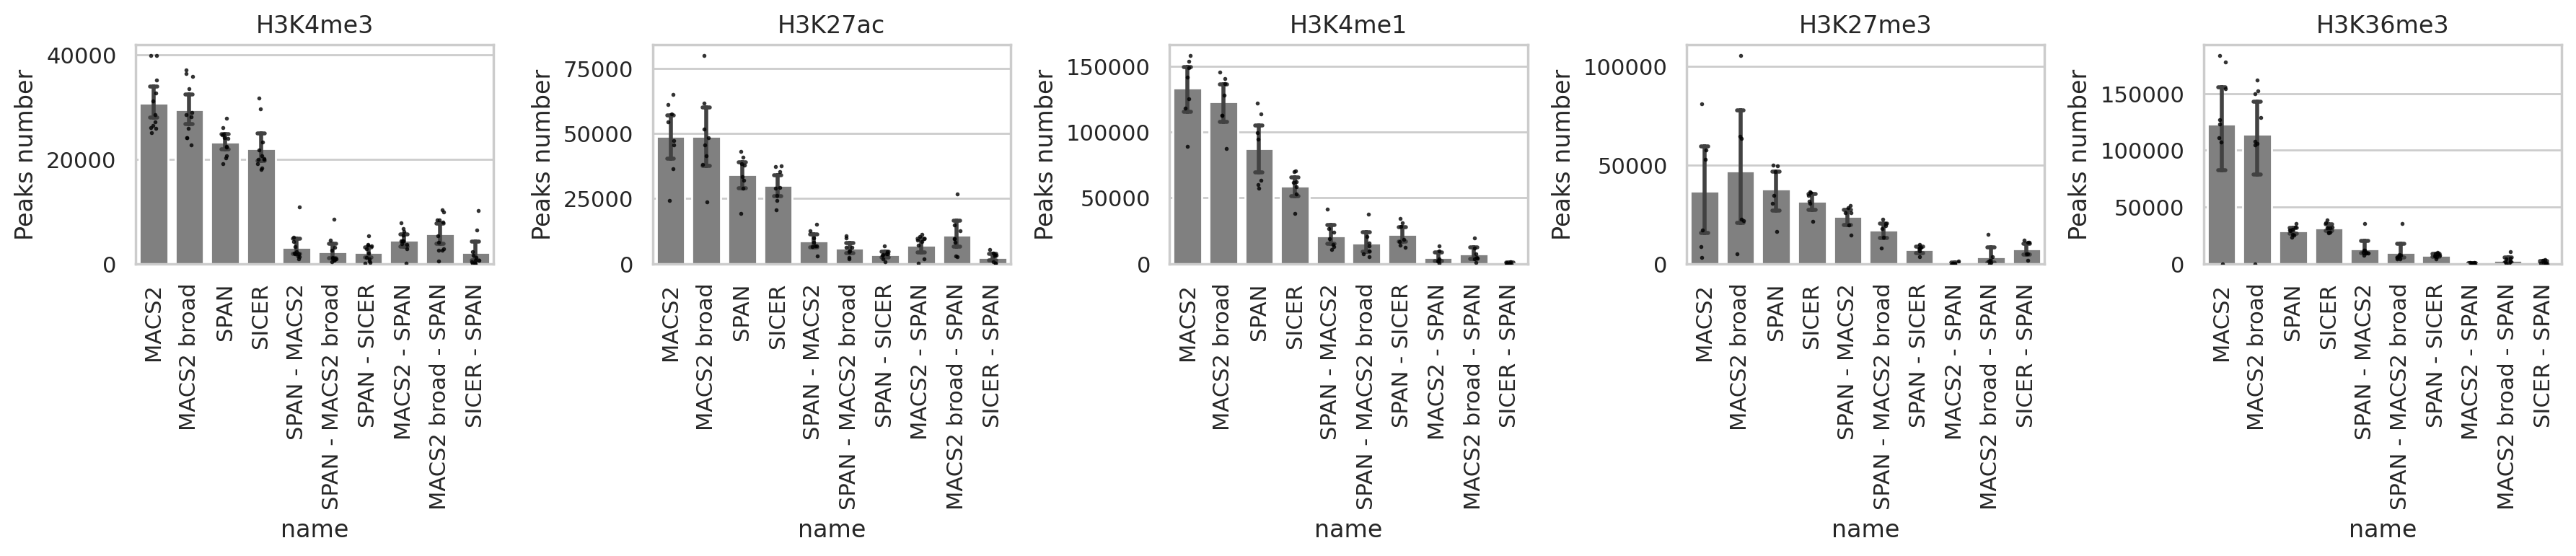

In [56]:
plot_diff(df_immune_peaks, df_immune_diff)

In [57]:
df_immune_diff[(df_immune_diff['modification'] == 'H3K27ac') &
               (df_immune_diff['name'] == 'MACS2 - SPAN')].sort_values(by=['peaks'], ascending=False).head(10)

modification      cell replicate          name  peaks
49      H3K27ac     TCell            MACS2 - SPAN  11168
19      H3K27ac       CD4            MACS2 - SPAN  10441
37      H3K27ac        NK            MACS2 - SPAN   9690
1       H3K27ac     BCell            MACS2 - SPAN   8936
31      H3K27ac  Monocyte            MACS2 - SPAN   8562
7       H3K27ac      CD34            MACS2 - SPAN   7219
13      H3K27ac      CD34      rep2  MACS2 - SPAN   3939
25      H3K27ac       CD4      rep1  MACS2 - SPAN   1824
43      H3K27ac      PBMC            MACS2 - SPAN    140

## ABF

In [58]:
dp = f'{ABF_PATH}/diff'
! mkdir -p {dp}

df_abf_diff = compute_diffs(dp, df_abf_peaks)
df_abf_diff.sample(5)

  0%|          | 0/165 [00:00<?, ?it/s]

H3K27ac OD OD1
H3K27ac OD OD10
H3K27ac OD OD11
H3K27ac OD OD12
H3K27ac OD OD13
H3K27ac OD OD14
H3K27ac OD OD15
H3K27ac OD OD16
H3K27ac OD OD17
H3K27ac OD OD18
H3K27ac OD OD19
H3K27ac OD OD2
H3K27ac OD OD20
H3K27ac OD OD3
H3K27ac OD OD4
H3K27ac OD OD5
H3K27ac OD OD6
H3K27ac OD OD7
H3K27ac OD OD8
H3K27ac OD OD9
H3K27ac YD YD10
H3K27ac YD YD11
H3K27ac YD YD12
H3K27ac YD YD14
H3K27ac YD YD15
H3K27ac YD YD16
H3K27ac YD YD17
H3K27ac YD YD18
H3K27ac YD YD19
H3K27ac YD YD2
H3K27ac YD YD20
H3K27ac YD YD21
H3K27ac YD YD3
H3K27ac YD YD4
H3K27ac YD YD5
H3K27ac YD YD7
H3K27ac YD YD8
H3K27ac YD YD9
H3K27me3 OD OD1
H3K27me3 OD OD10
H3K27me3 OD OD11
H3K27me3 OD OD12
H3K27me3 OD OD13
H3K27me3 OD OD14
H3K27me3 OD OD15
H3K27me3 OD OD16
H3K27me3 OD OD17
H3K27me3 OD OD18
H3K27me3 OD OD19
H3K27me3 OD OD2
H3K27me3 OD OD20
H3K27me3 OD OD3
H3K27me3 OD OD4
H3K27me3 OD OD5
H3K27me3 OD OD6
H3K27me3 OD OD7
H3K27me3 OD OD8
H3K27me3 YD YD12
H3K27me3 YD YD14
H3K27me3 YD YD15
H3K27me3 YD YD16
H3K27me3 YD YD17
H3K27me3

modification cell replicate          name  peaks
960      H3K4me3   YD       YD5  SPAN - MACS2  36402
425     H3K36me3   OD       OD1  SICER - SPAN   7734
406     H3K27me3   YD       YD6  SPAN - SICER   8289
856      H3K4me3   OD       OD2  SPAN - SICER   6773
773      H3K4me1   YD       YD6  SICER - SPAN    665

H3K4me3 1650
H3K27ac 1650
H3K4me1 1650
H3K27me3 1650
H3K36me3 1650


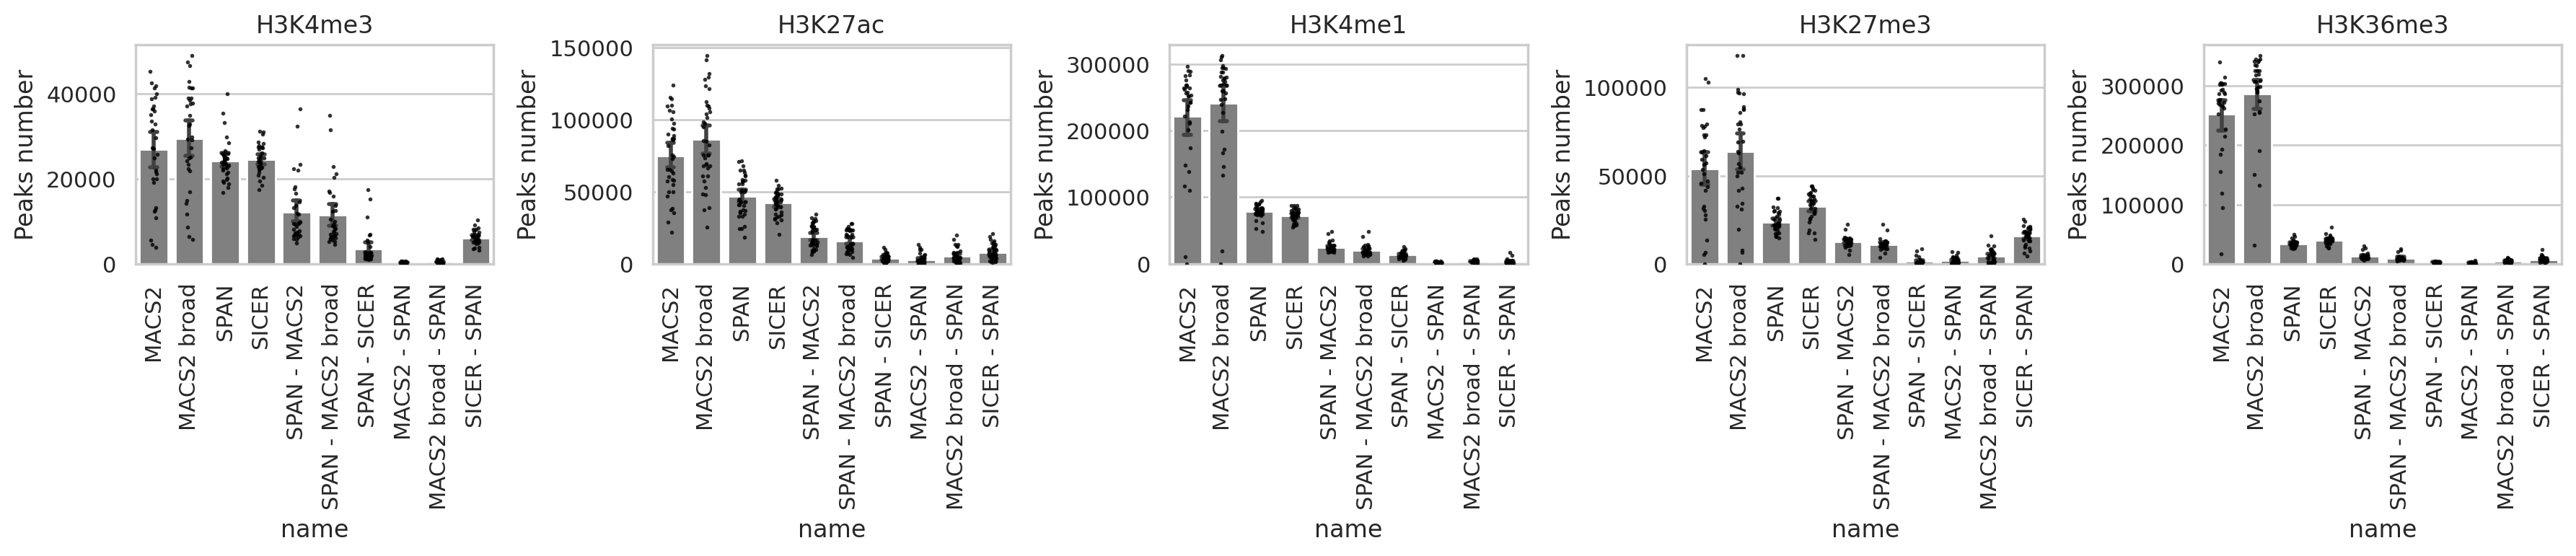

In [59]:
plot_diff(df_abf_peaks, df_abf_diff)


# Jaccard & Overlap

In [36]:
import pyranges as pr
import tempfile


def compute_reps_overlap(df_peaks):
    reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                         'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                         'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    for (m, c, tool), tm in tqdm(df_peaks.groupby(['modification', 'cell', 'tool'])):
        reps = list(sorted(set(tm['replicate'])))
        print(m, c, tool, len(reps))
        files = [None] * len(reps)
        peaks = [-1] * len(reps)
        peaks_lens = [-1] * len(reps)
        # print('Load')
        for i in range(len(reps)):
            t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == reps[i])]
            if len(t1) == 0:
                continue
            file = t1['file'].values[0]
            peaks[i] = lines(file)
            if peaks[i] == 0:
                peaks_lens[i] = 0
                continue
            files[i] = pr.read_bed(sorted_file(file))
            peaks_lens[i] = files[i].lengths().sum()
            # print('Intersect')
        for i, j in product(range(len(reps)), range(len(reps))):
            if i >= j:
                continue
            rep1, rep2 = reps[i], reps[j]
            file1, file2 = files[i], files[j]
            peaks1, peaks2 = peaks[i], peaks[j]
            peaks1_len, peaks2_len = peaks_lens[i], peaks_lens[j]
            if peaks1 <= 0 or peaks2 <= 0:
                reps_overlap.loc[len(reps_overlap)] = \
                    (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     0, 0, 0)
                continue
            overlap1 = len(file1.overlap(file2))
            overlap2 = len(file2.overlap(file1))
            overlap_len = file1.intersect(file2).lengths().sum()
            # assert file2.intersect(file1).lengths().sum() == overlap_len
            reps_overlap.loc[len(reps_overlap)] = \
                (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                 overlap1, overlap2, overlap_len)
    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]
    return reps_overlap

## Jaccard ENCODE 

In [37]:
t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
df_encode_reps = compute_reps_overlap(t)
df_encode_reps.sample(5)

  0%|          | 0/360 [00:00<?, ?it/s]

H3K27ac GM12878 HOMER 2
H3K27ac GM12878 Hotspot 2
H3K27ac GM12878 LanceOtron 2
H3K27ac GM12878 MACS2 2
H3K27ac GM12878 MACS2 broad 2
H3K27ac GM12878 Peakseq 2
H3K27ac GM12878 SICER 2
H3K27ac GM12878 SPAN 2
H3K27ac H1 HOMER 1
H3K27ac H1 Hotspot 1
H3K27ac H1 LanceOtron 1
H3K27ac H1 MACS2 1
H3K27ac H1 MACS2 broad 1
H3K27ac H1 Peakseq 1
H3K27ac H1 SICER 1
H3K27ac H1 SPAN 1
H3K27ac HMEC HOMER 2
H3K27ac HMEC Hotspot 2
H3K27ac HMEC LanceOtron 2
H3K27ac HMEC MACS2 2
H3K27ac HMEC MACS2 broad 2
H3K27ac HMEC Peakseq 2
H3K27ac HMEC SICER 2
H3K27ac HMEC SPAN 2
H3K27ac HSMM HOMER 2
H3K27ac HSMM Hotspot 2
H3K27ac HSMM LanceOtron 2
H3K27ac HSMM MACS2 2
H3K27ac HSMM MACS2 broad 2
H3K27ac HSMM Peakseq 2
H3K27ac HSMM SICER 2
H3K27ac HSMM SPAN 2
H3K27ac HepG2 HOMER 2
H3K27ac HepG2 Hotspot 2
H3K27ac HepG2 LanceOtron 2
H3K27ac HepG2 MACS2 2
H3K27ac HepG2 MACS2 broad 2
H3K27ac HepG2 Peakseq 2
H3K27ac HepG2 SICER 2
H3K27ac HepG2 SPAN 2
H3K27ac Huvec HOMER 2
H3K27ac Huvec Hotspot 2
H3K27ac Huvec LanceOtron 2
H

modification   cell     tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
166     H3K36me3   HSMM    SICER  rep1  rep2   50627   364738573   45580   
231      H3K4me1   HSMM     SPAN  rep1  rep2   87039   112352110   92007   
232      H3K4me1  Huvec    HOMER  rep1  rep2   69338   110057464   58515   
131     H3K27me3   NHLF    MACS2  rep1  rep2     346      144678   59893   
233      H3K4me1  Huvec  Hotspot  rep1  rep2  200420   153814411  233798   

     peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
166   363253620           35126           30320          247079727  0.513773  
231   190529810           75932           57586           97625205  0.475625  
232    87558725           44575           45936           61211522  0.448749  
131    32933498             321             285             126951  0.003853  
233   174675277          167326          170100          117743503  0.558698

ENCODE


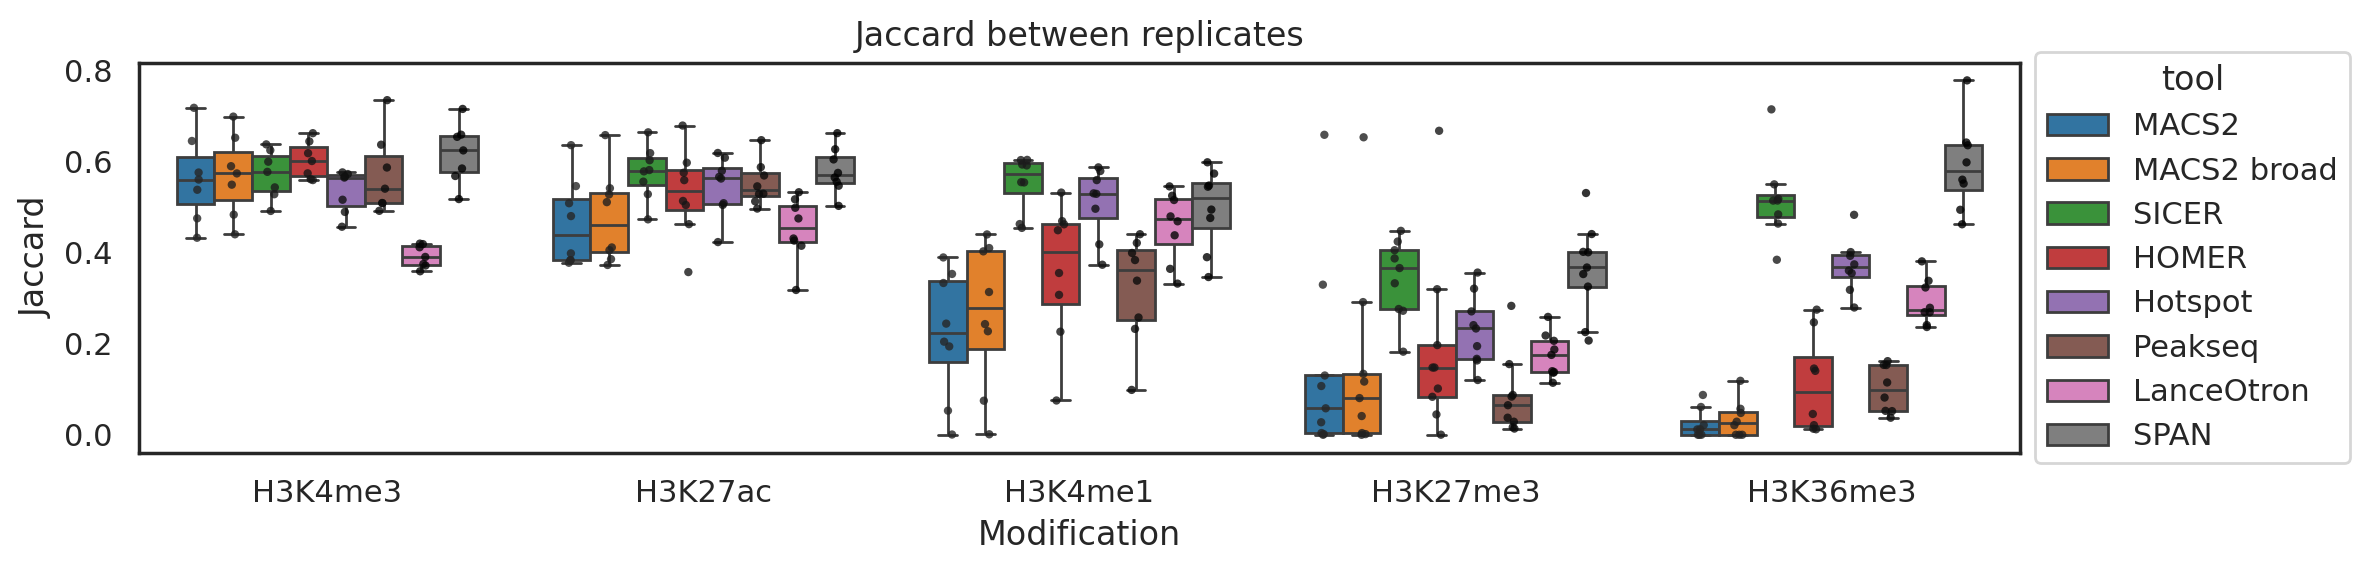

In [38]:
print('ENCODE')
plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=TOOLS,
            showfliers=False,
            ax=ax)
sns.stripplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=TOOLS,
              legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


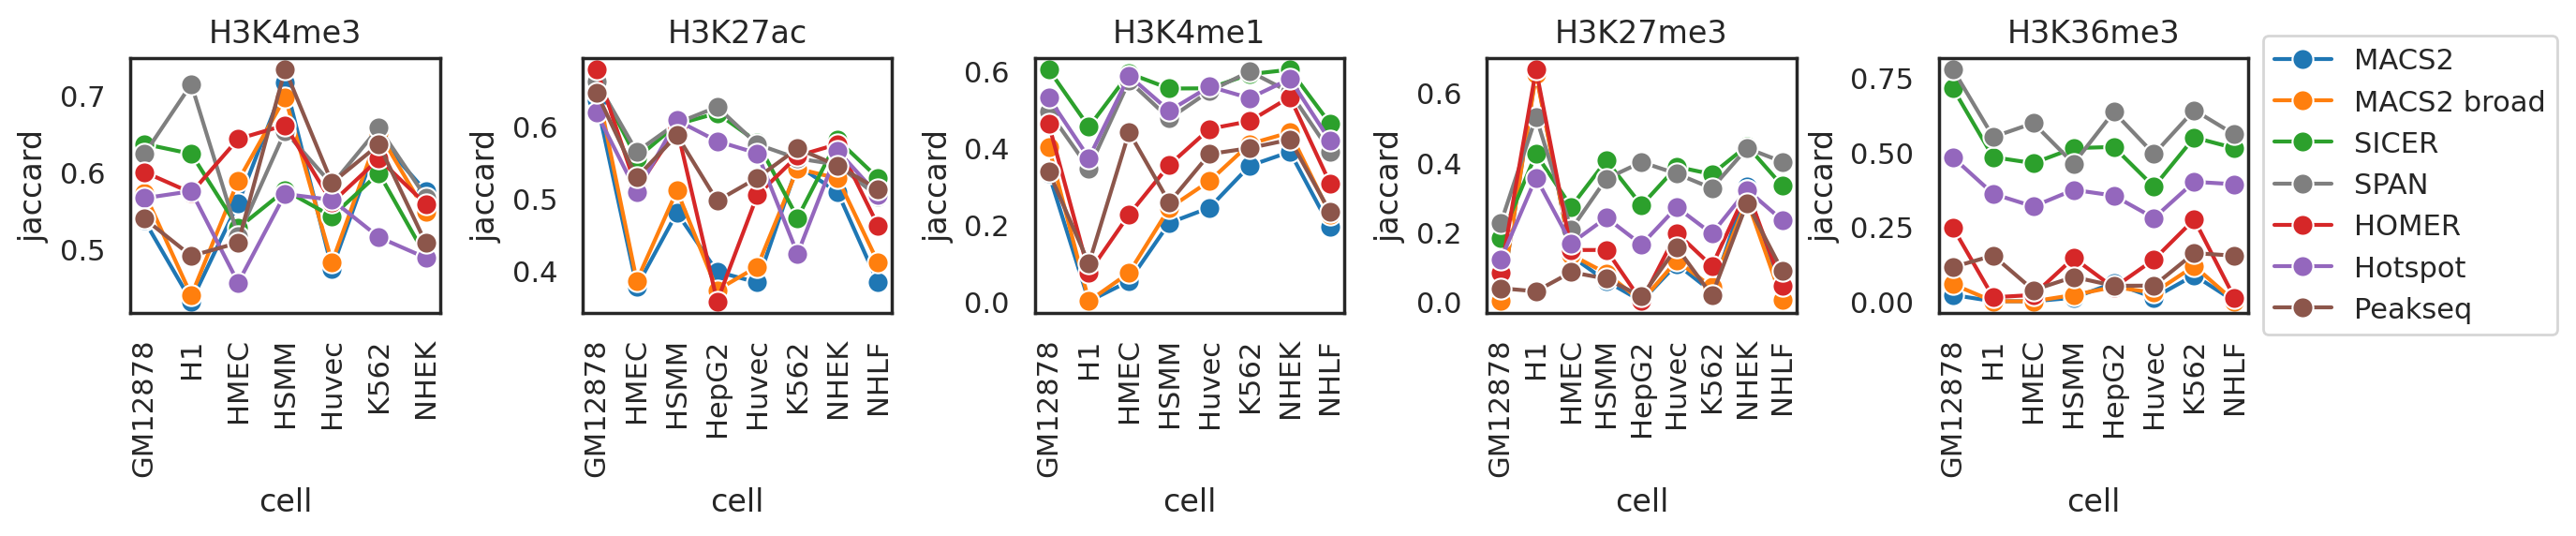

In [39]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN', 'HOMER', 'Hotspot', 'Peakseq'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

ENCODE


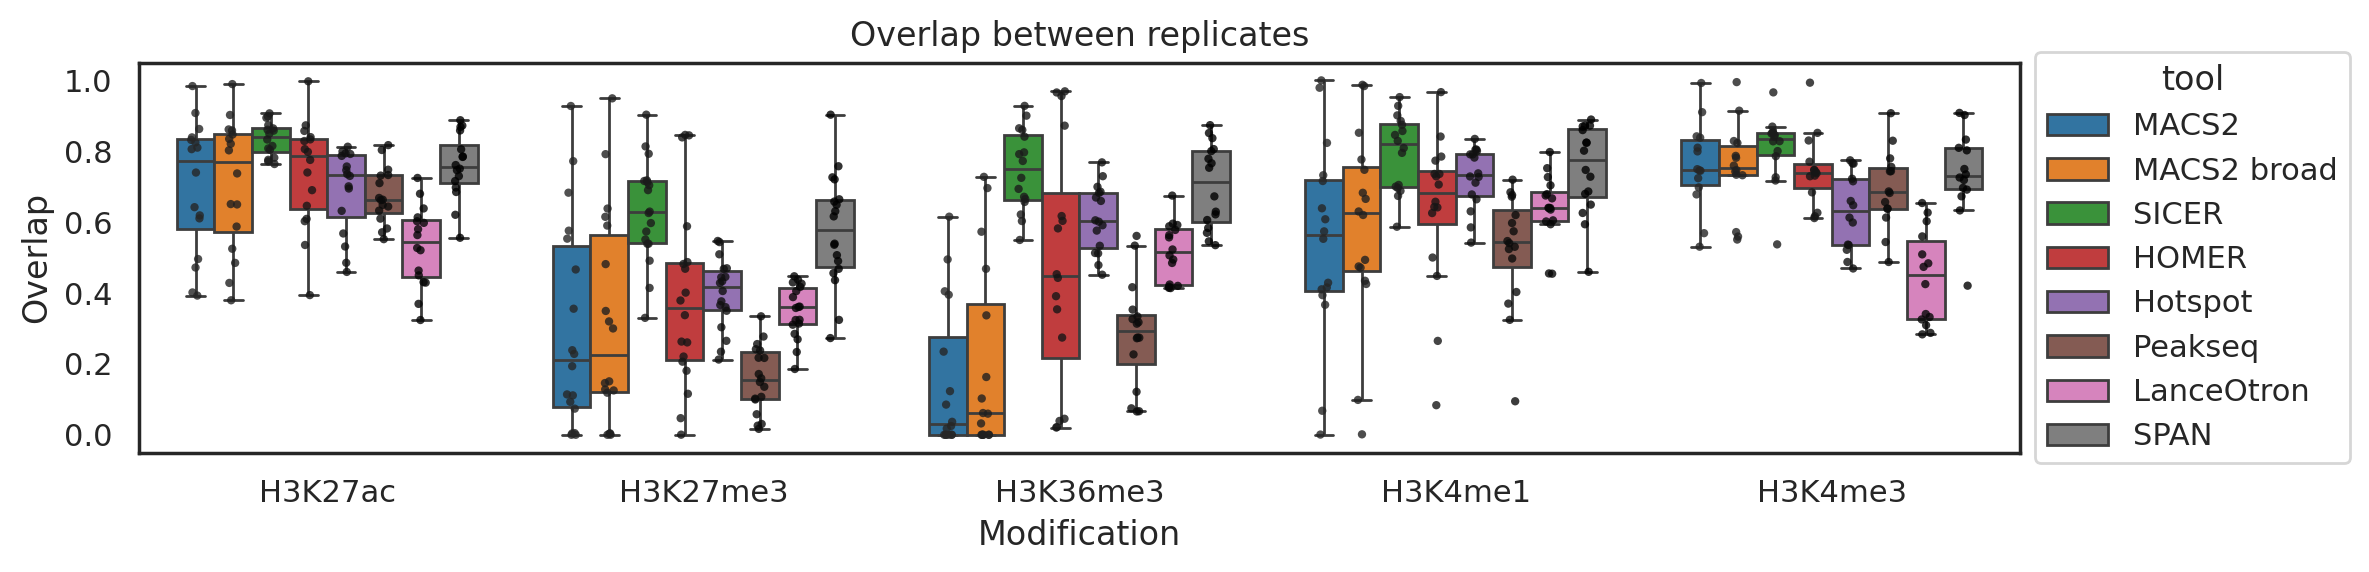

In [40]:
t = pd.concat([df_encode_reps[['modification', 'cell', 'tool']],
               df_encode_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_encode_reps['peaks1_overlap'], df_encode_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_encode_reps['peaks2_overlap'], df_encode_reps['peaks2'])]
t['overlap'] = overlaps
print('ENCODE')
plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            showfliers=False
            )
sns.stripplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=TOOLS,
              legend=False,
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE
H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


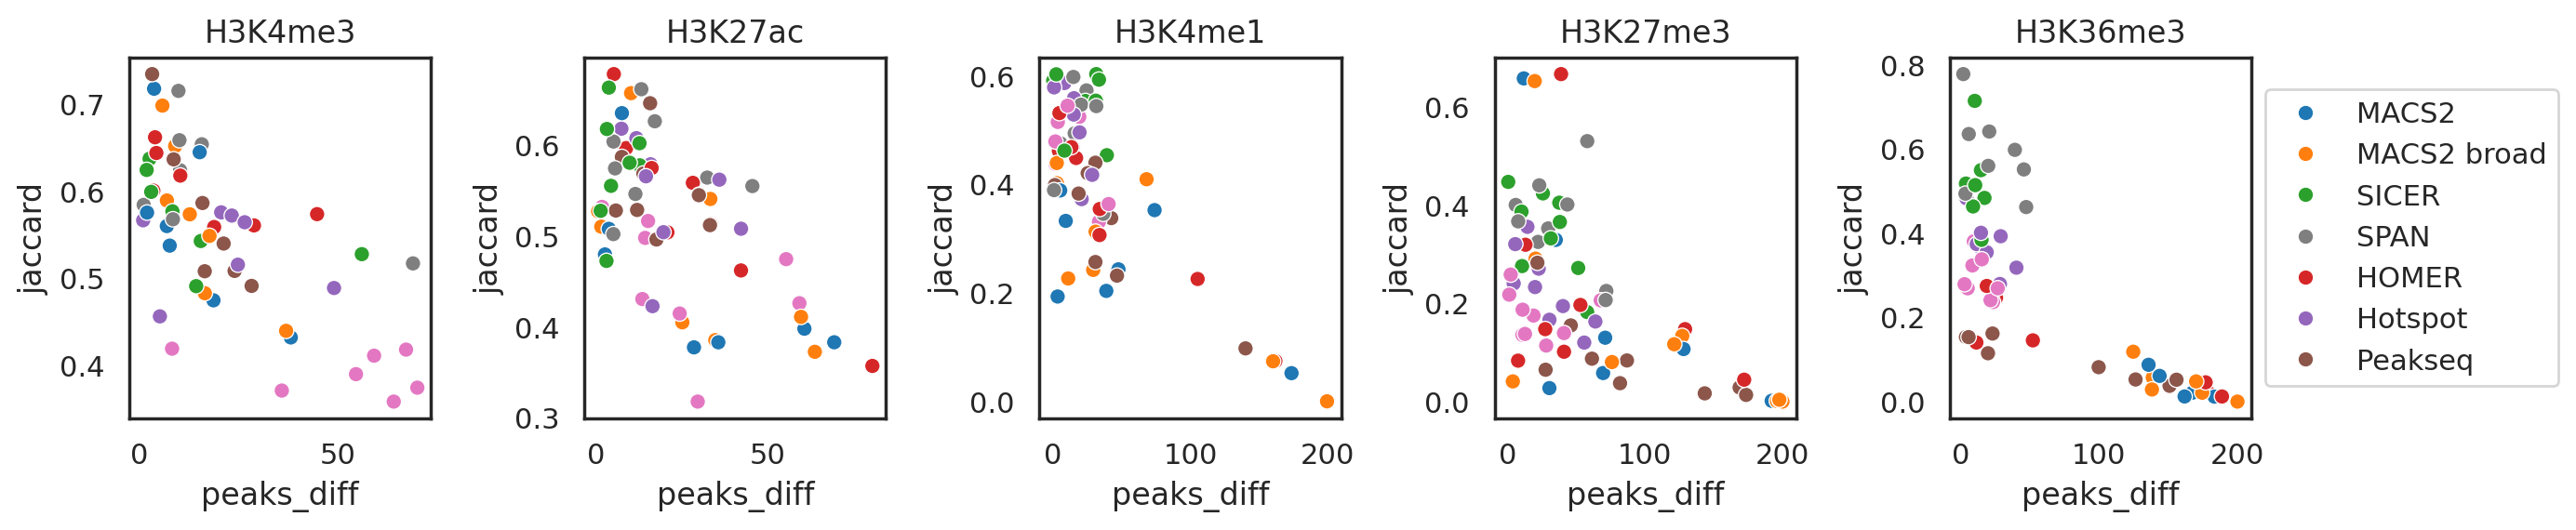

In [41]:
print('ENCODE')
df_encode_reps['peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                       (df_encode_reps['peaks1'] + df_encode_reps['peaks2']) * 200)
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN', 'HOMER', 'Hotspot', 'Peakseq'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

ENCODE


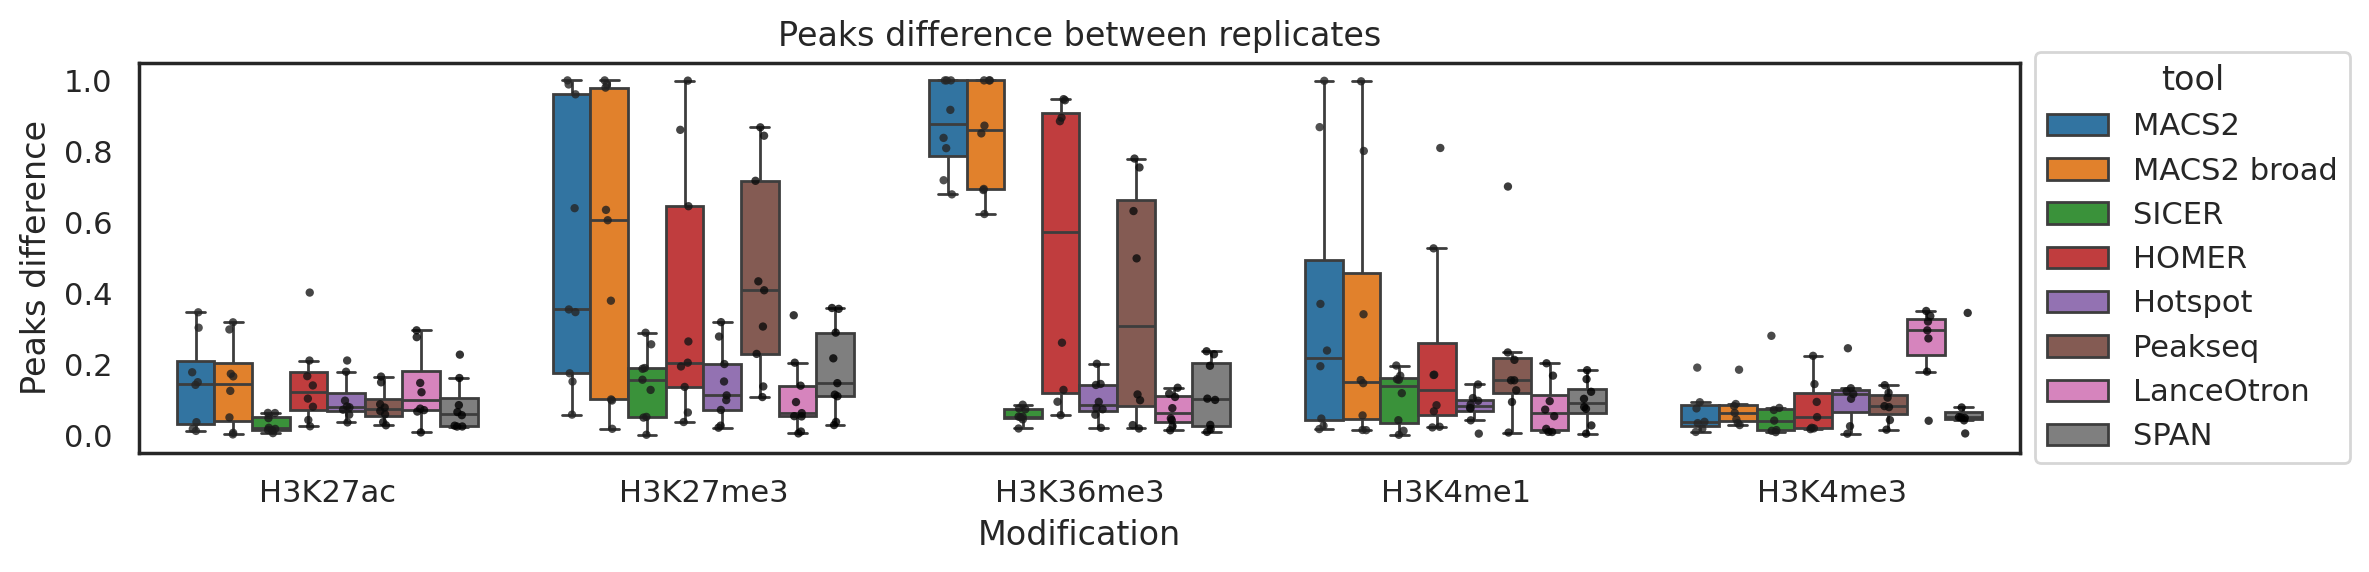

In [42]:
print('ENCODE')
df_encode_reps['reps_peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                            (df_encode_reps['peaks1'] + df_encode_reps['peaks2']))

plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            showfliers=False,
            ax=ax)
sns.stripplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=TOOLS, legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [43]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_encode_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_encode = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

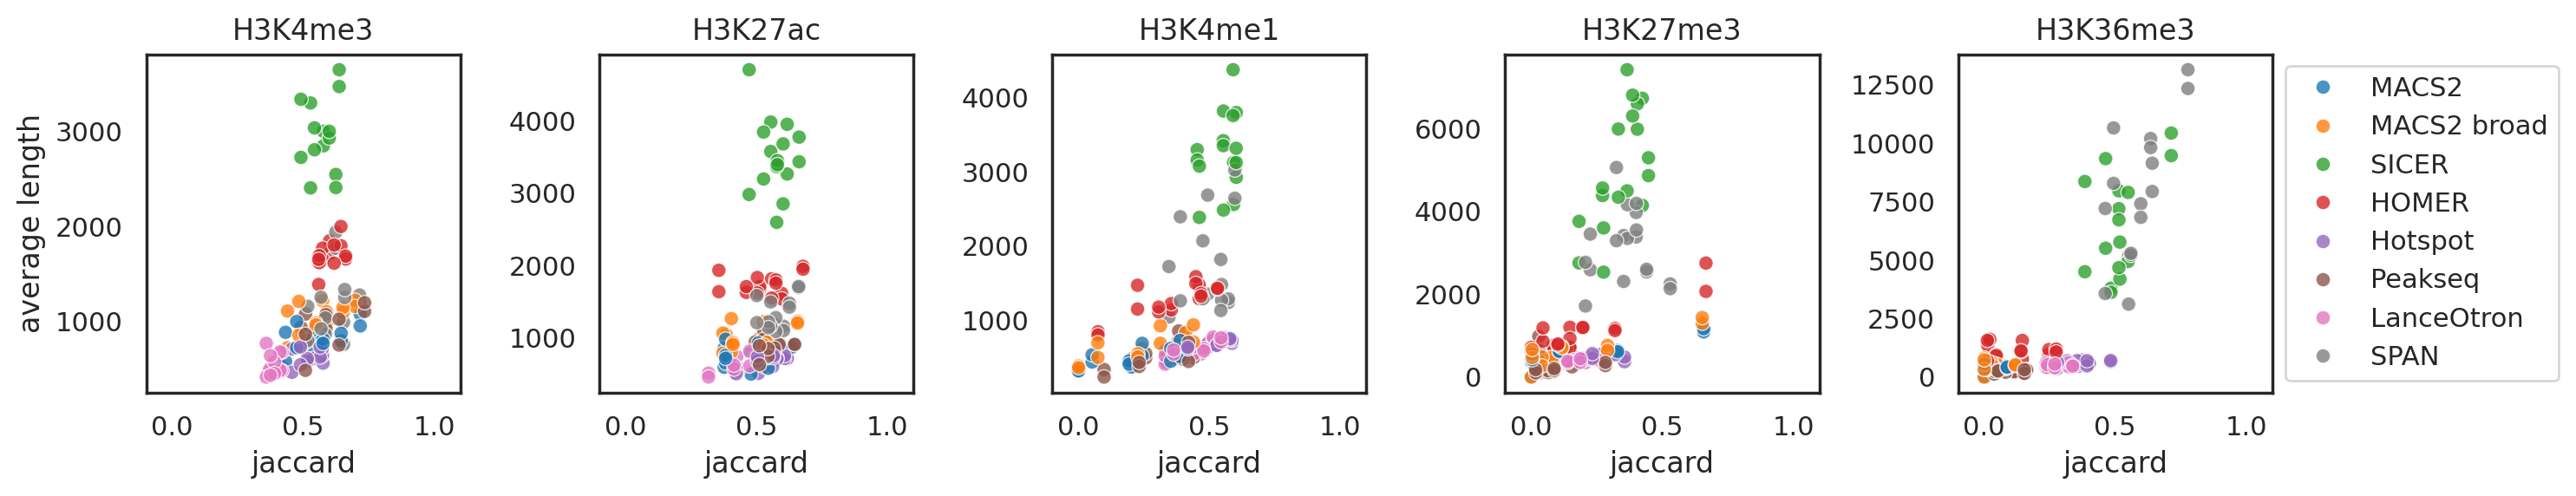

In [44]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K27ac


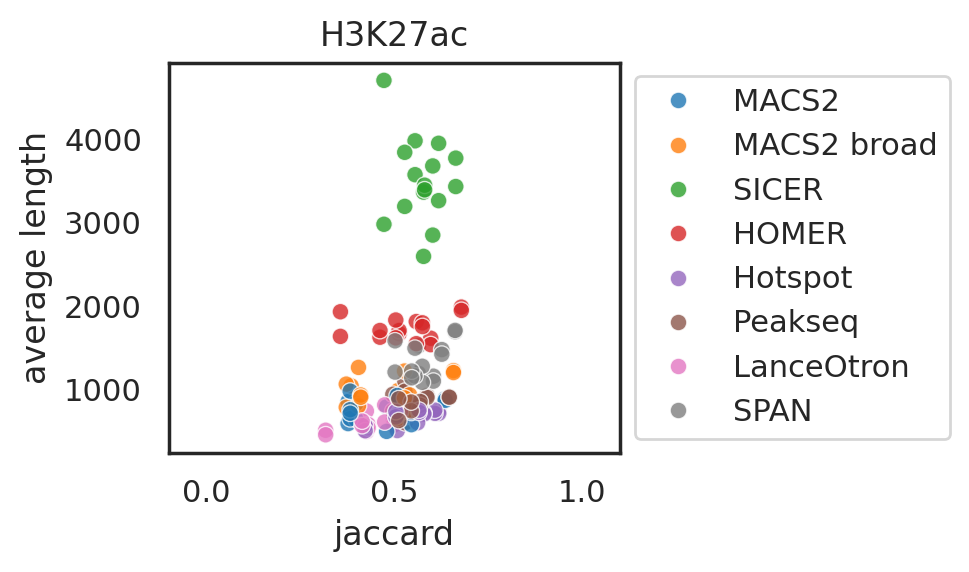

H3K4me1


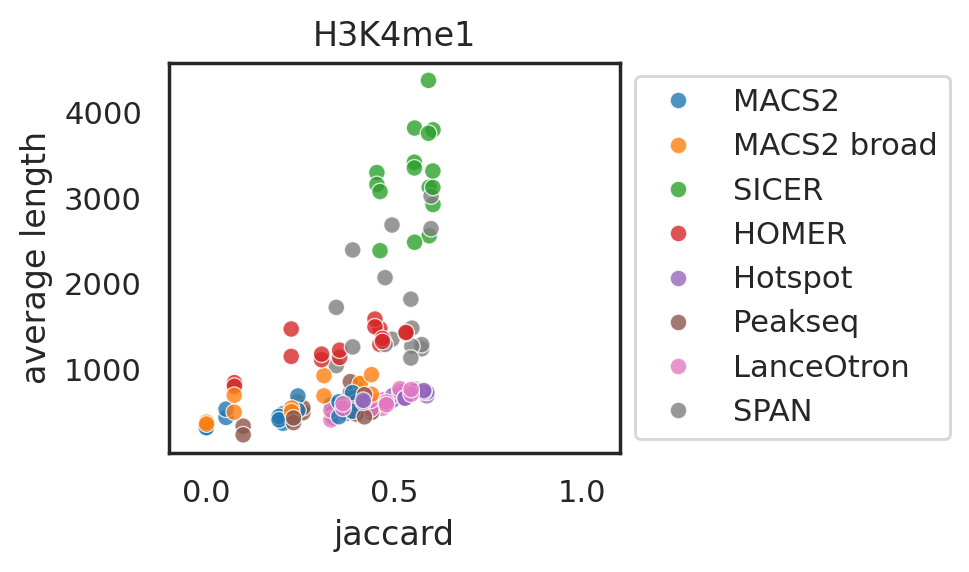

In [45]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    ax.set_ylabel('average length')
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

## Jaccard Roadmap

In [46]:
t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_immune_peaks
df_immune_reps = compute_reps_overlap(t)
df_immune_reps.sample(5)

  0%|          | 0/240 [00:00<?, ?it/s]

H3K27ac BCell HOMER 1
H3K27ac BCell Hotspot 1
H3K27ac BCell LanceOtron 1
H3K27ac BCell MACS2 1
H3K27ac BCell MACS2 broad 1
H3K27ac BCell Peakseq 1
H3K27ac BCell SICER 1
H3K27ac BCell SPAN 1
H3K27ac CD34 HOMER 1
H3K27ac CD34 Hotspot 1
H3K27ac CD34 LanceOtron 1
H3K27ac CD34 MACS2 1
H3K27ac CD34 MACS2 broad 1
H3K27ac CD34 Peakseq 1
H3K27ac CD34 SICER 1
H3K27ac CD34 SPAN 1
H3K27ac CD4 HOMER 2
H3K27ac CD4 Hotspot 2
H3K27ac CD4 LanceOtron 2
H3K27ac CD4 MACS2 2
H3K27ac CD4 MACS2 broad 2
H3K27ac CD4 Peakseq 2
H3K27ac CD4 SICER 2
H3K27ac CD4 SPAN 2
H3K27ac Monocyte HOMER 1
H3K27ac Monocyte Hotspot 1
H3K27ac Monocyte LanceOtron 1
H3K27ac Monocyte MACS2 1
H3K27ac Monocyte MACS2 broad 1
H3K27ac Monocyte Peakseq 1
H3K27ac Monocyte SICER 1
H3K27ac Monocyte SPAN 1
H3K27ac NK HOMER 1
H3K27ac NK Hotspot 1
H3K27ac NK LanceOtron 1
H3K27ac NK MACS2 1
H3K27ac NK MACS2 broad 1
H3K27ac NK Peakseq 1
H3K27ac NK SICER 1
H3K27ac NK SPAN 1
H3K27ac PBMC HOMER 1
H3K27ac PBMC Hotspot 1
H3K27ac PBMC LanceOtron 1
H3K2

modification     cell        tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
1       H3K27ac      CD4     Hotspot        rep1  171200   121899975  108046   
49      H3K4me1      CD4     Hotspot        rep1  282747   217613369  235658   
50      H3K4me1      CD4  LanceOtron        rep1  181794   131568526  153570   
78      H3K4me3  TCellBB       SICER  rep1  rep2   31721    59642679   29667   
25     H3K36me3     CD34     Hotspot        rep1  352224   289805013  298227   

    peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
1     54394530           68528           62847           43793405  0.330514  
49   161644129          203642          197071          140898456  0.591119  
50    99814270          114753          123616           79574472  0.524177  
78    67583133           24491           23646           45265661  0.552289  
25   184519380          251821          233046          163288032  0.524981

Immune


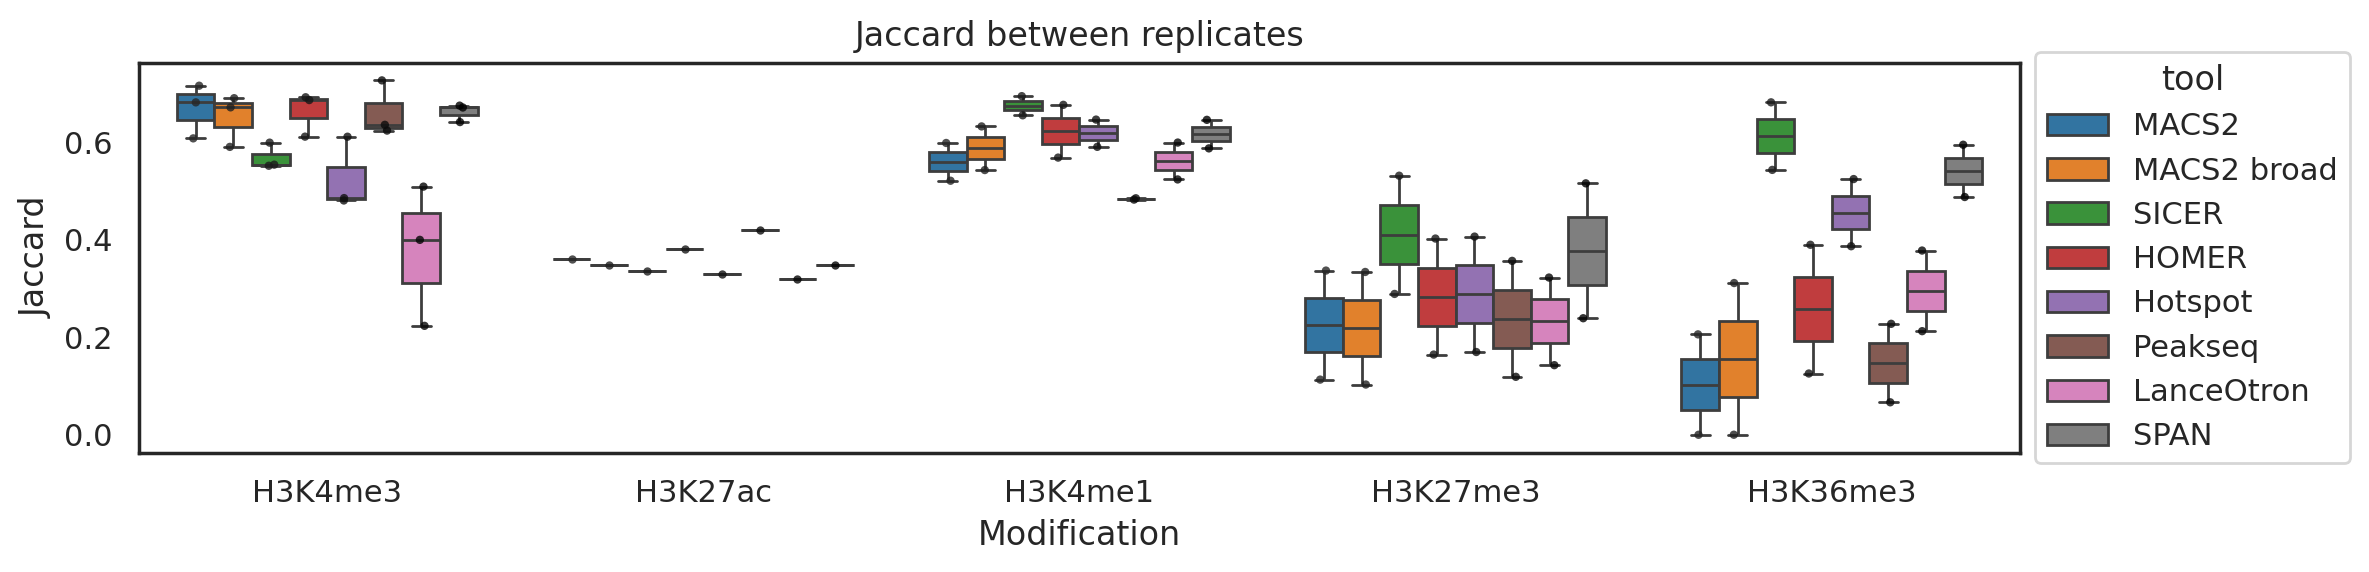

In [47]:
print('Immune')
plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=TOOLS,
            ax=ax)
sns.stripplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=TOOLS,
              legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


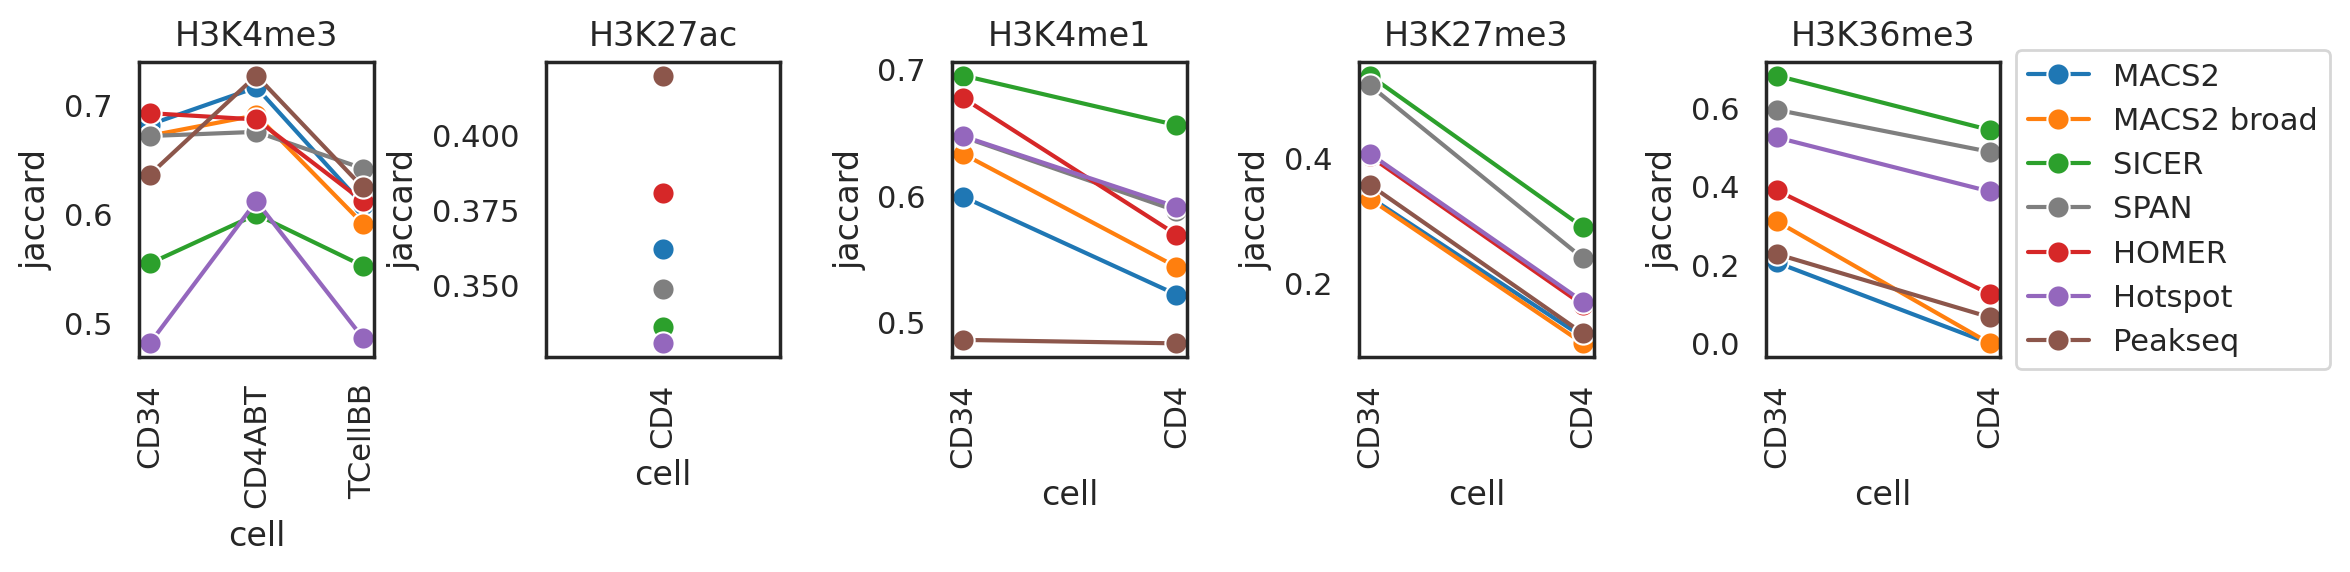

In [48]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN', 'HOMER', 'Hotspot', 'Peakseq'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

Immune


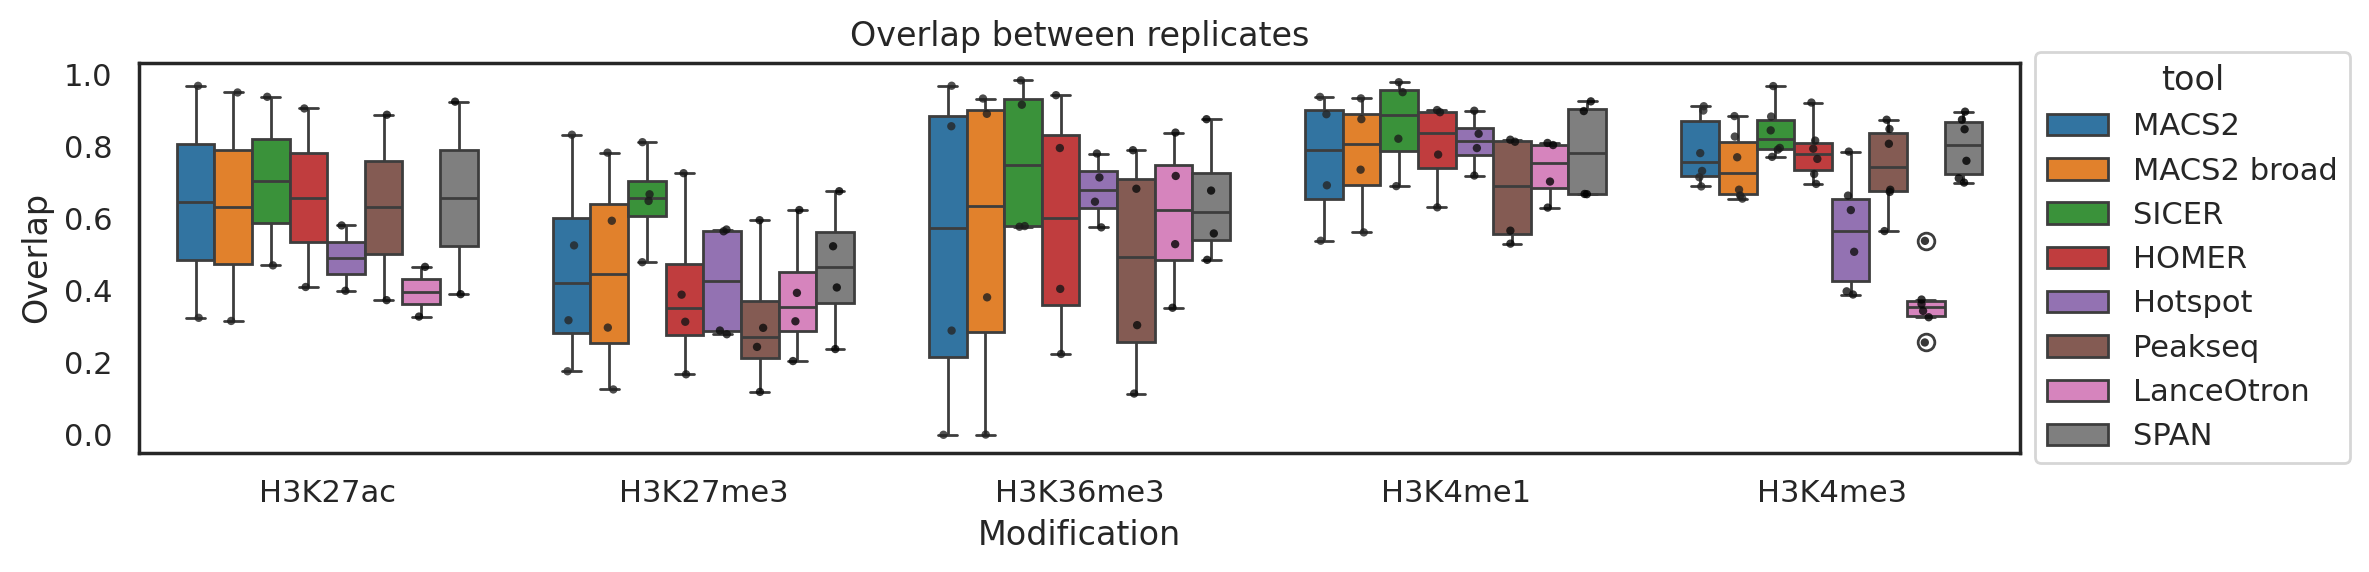

In [49]:
print('Immune')
t = pd.concat([df_immune_reps[['modification', 'cell', 'tool']],
               df_immune_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_immune_reps['peaks1_overlap'], df_immune_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_immune_reps['peaks2_overlap'], df_immune_reps['peaks2'])]
t['overlap'] = overlaps
plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            ax=ax)
sns.stripplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=TOOLS,
              legend=False,
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


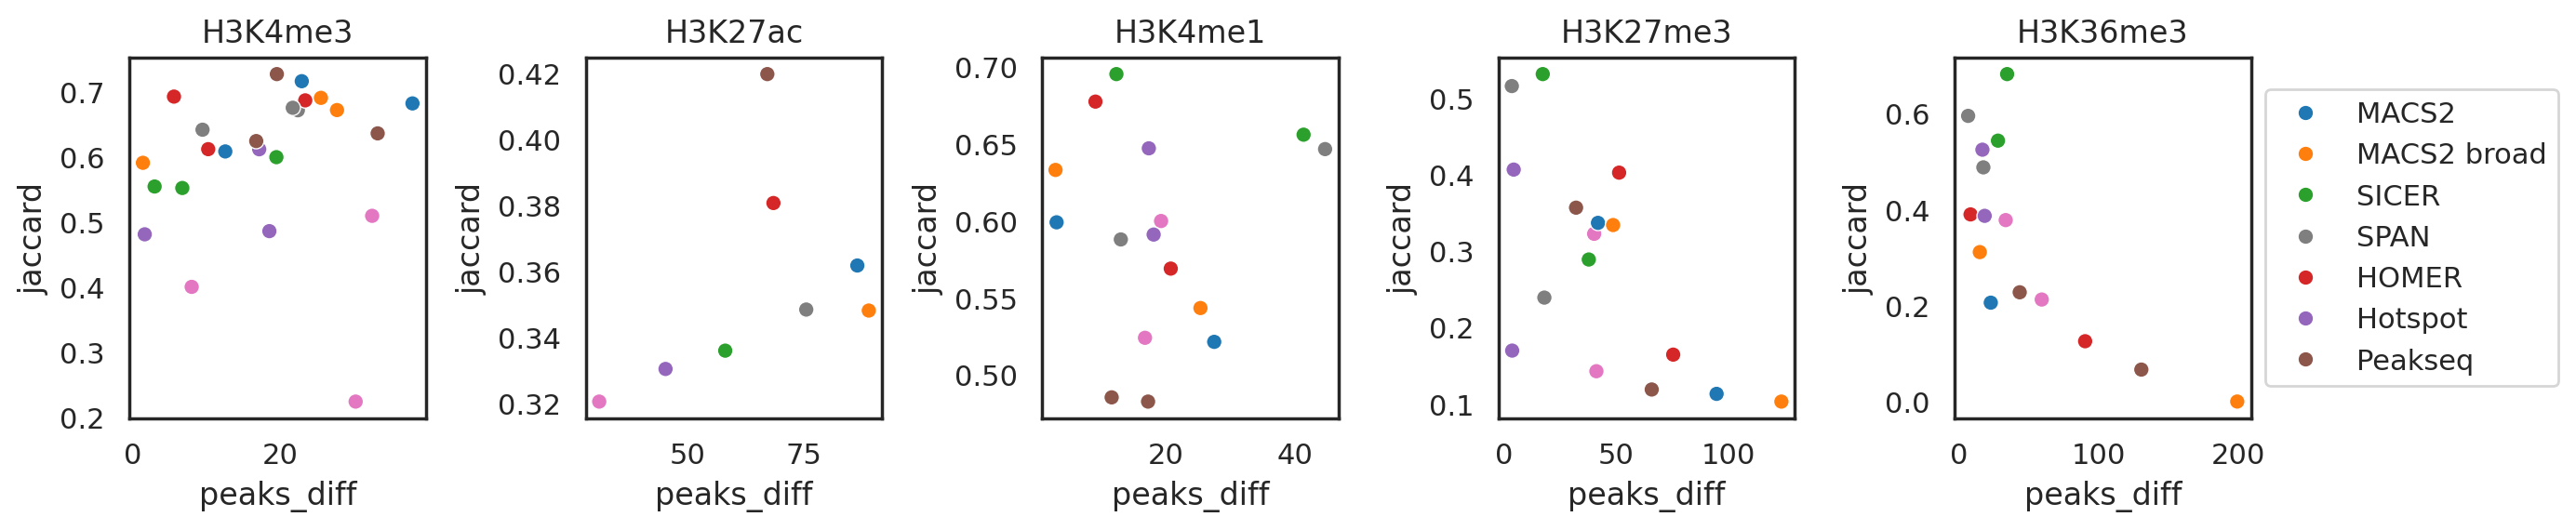

In [50]:
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) /
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']) * 200)

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN', 'HOMER', 'Hotspot', 'Peakseq'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Immune


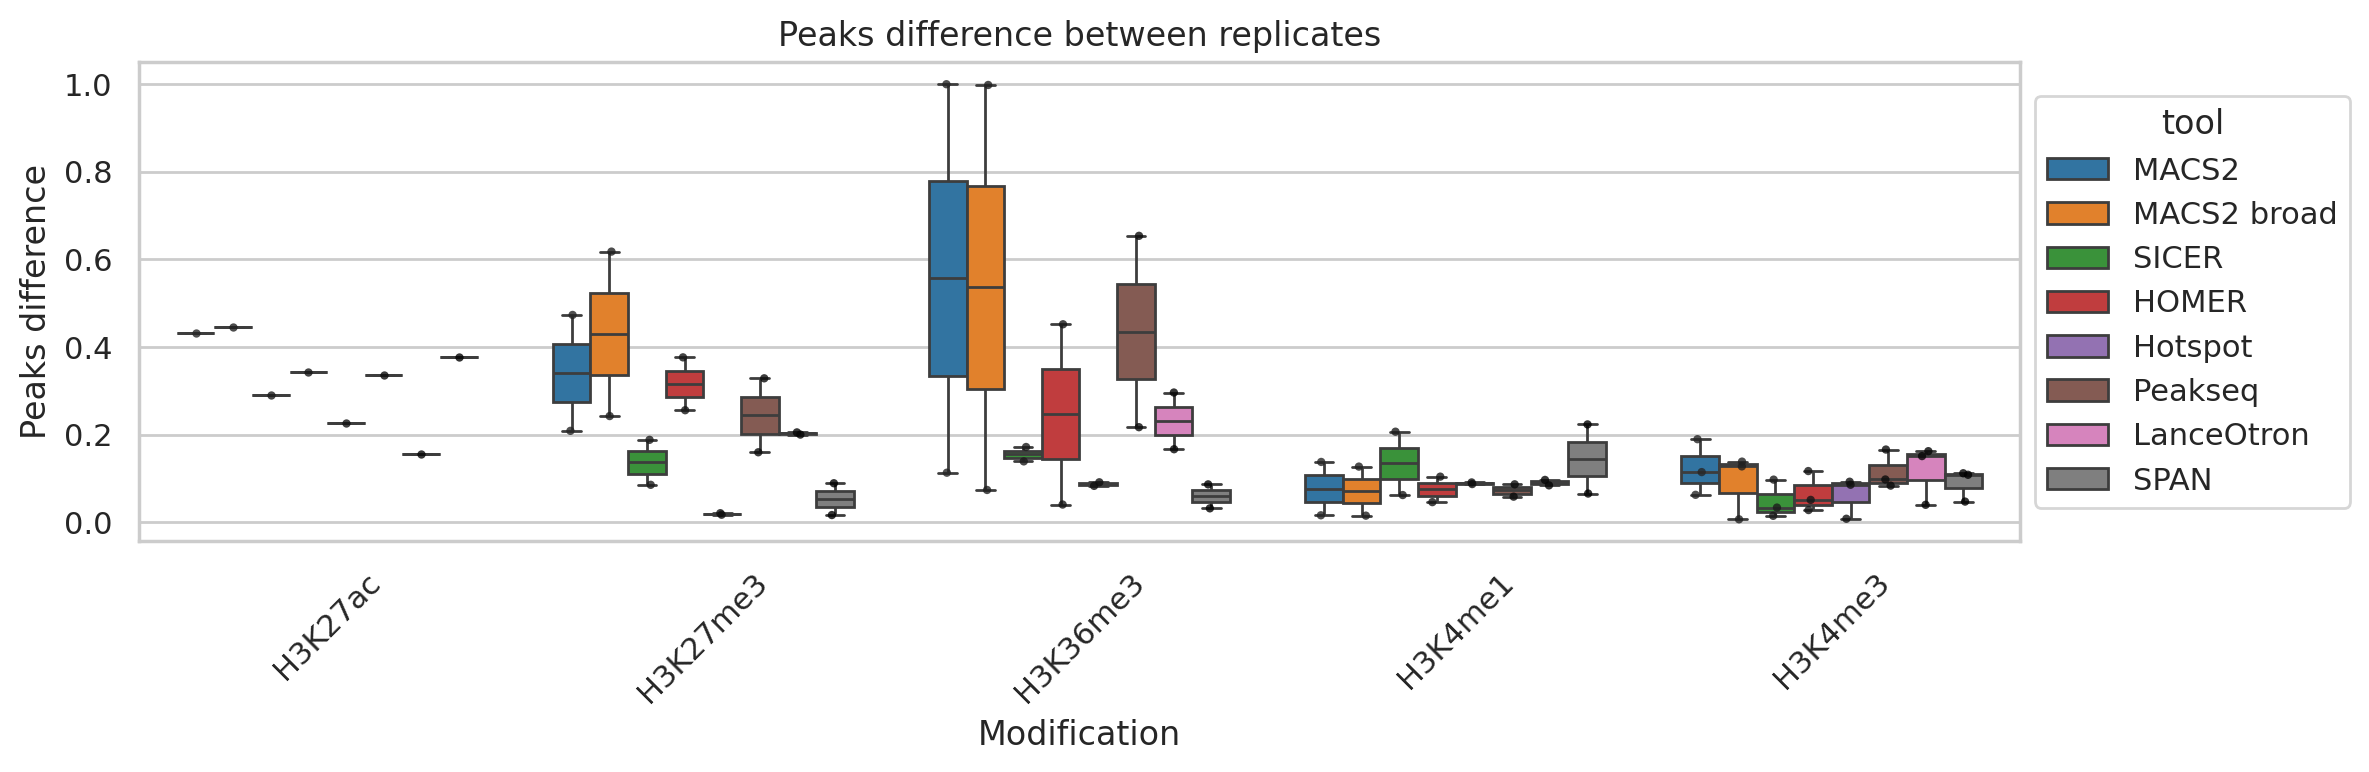

In [51]:
sns.set_style('whitegrid')
print('Immune')
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) /
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']))

plt.figure(figsize=(12, 4))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='peaks_diff',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            showfliers=False,
            ax=ax)
sns.stripplot(data=df_immune_reps, x='modification', hue='tool', y='peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=TOOLS,
              legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [52]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_immune_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_immune = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

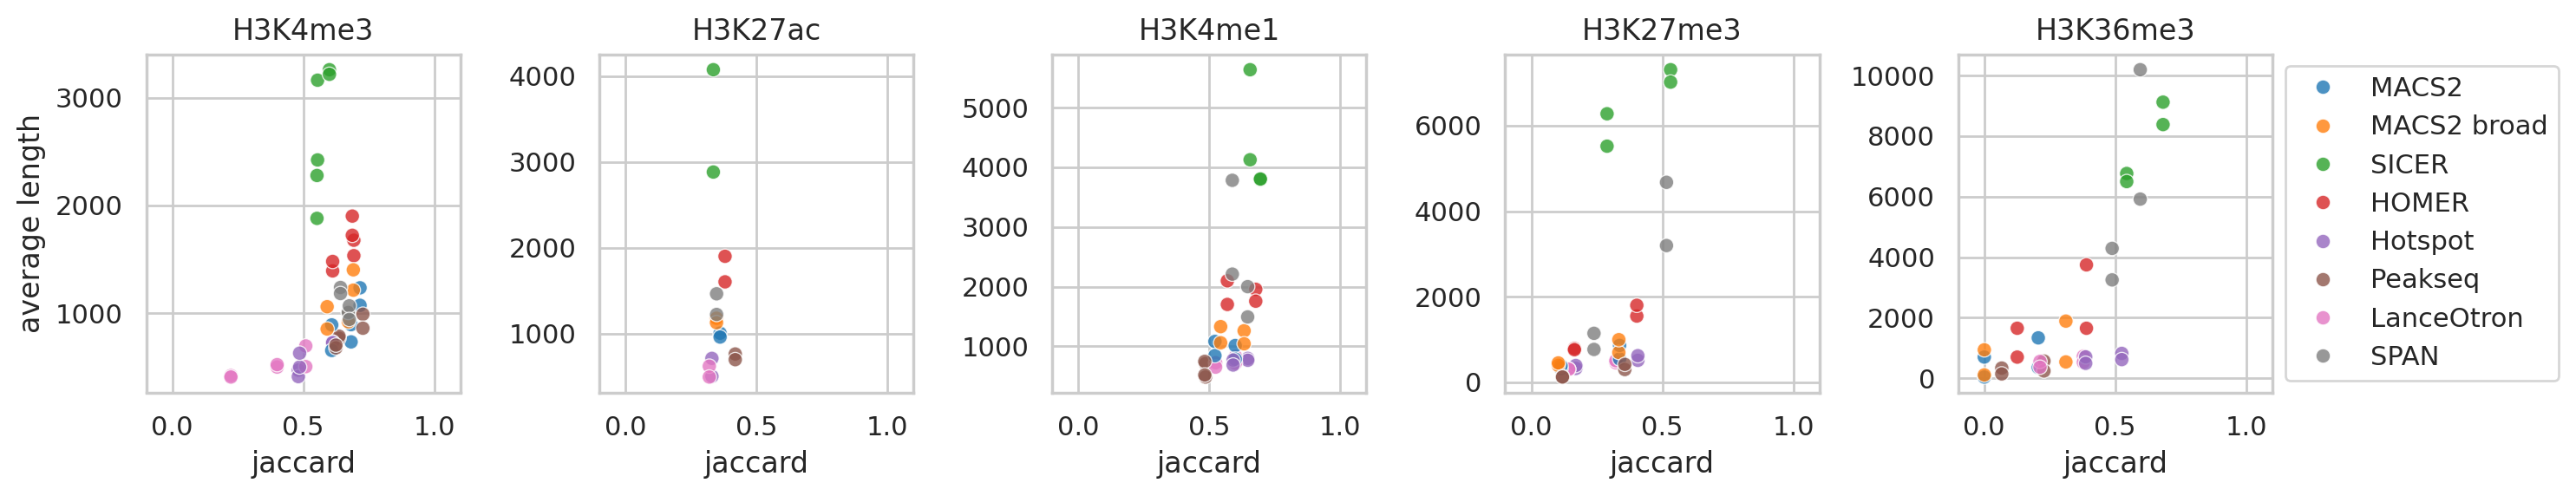

In [53]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_immune[df_jaccard_avg_len_immune['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        #     Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## All

ENCODE + Roadmap


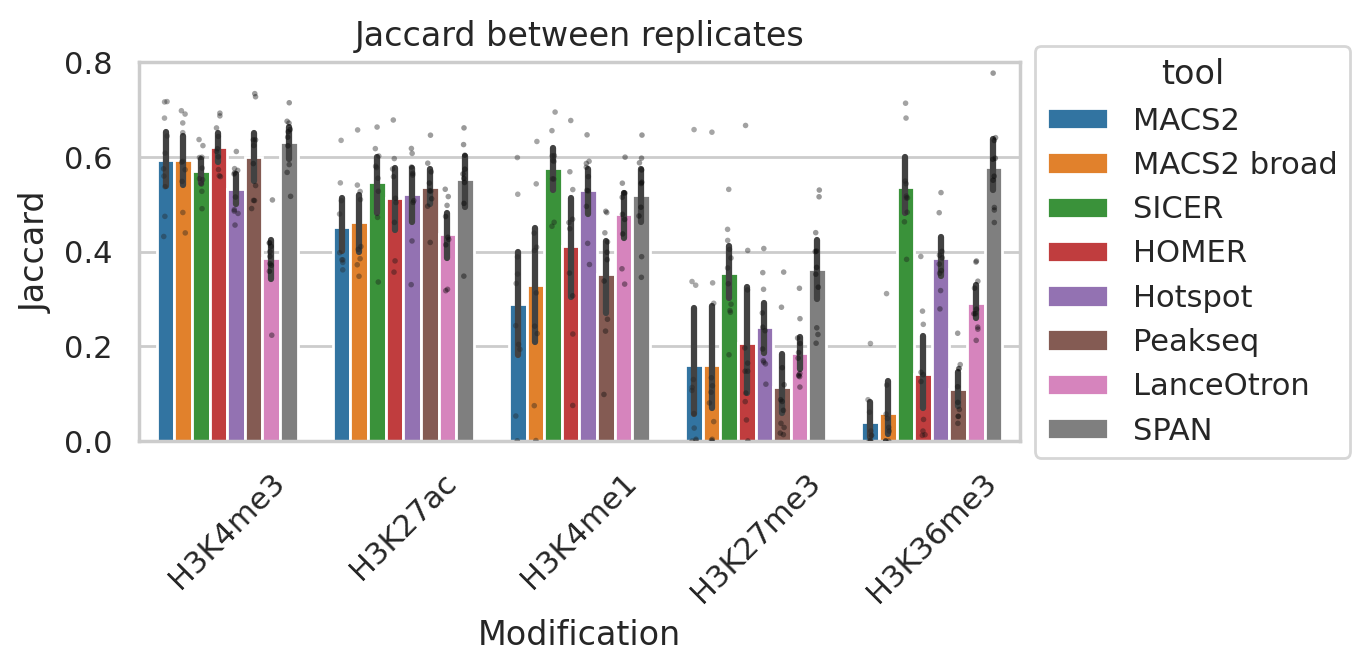

In [54]:
print('ENCODE + Roadmap')
sns.set_style("whitegrid")
t = pd.concat([df_encode_reps, df_immune_reps]).reset_index(drop=True)
plt.figure(figsize=(7, 3.5))
ax = plt.axes()
sns.barplot(data=t, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=TOOLS,
            # capsize=.2, err_kws={'linewidth': 2},
            ax=ax)
sns.stripplot(data=t, x='modification', hue='tool', y='jaccard',
              dodge=True, size=2, palette='dark:black',
              order=MODIFICATIONS,
              hue_order=TOOLS,
              legend=False, alpha=0.4,
              ax=ax)
ax.set_ylim(0, 0.8)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [55]:
ts = []
# for df in [df_encode_reps, df_immune_reps, df_abf_reps]:
for df in [df_encode_reps, df_immune_reps]:
    t = pd.concat([df[['modification', 'cell', 'tool']],
                   df[['modification', 'cell', 'tool']]]).reset_index(drop=True)
    overlaps = [d(o, p) for o, p in zip(df['peaks1_overlap'], df['peaks1'])] + \
               [d(o, p) for o, p in zip(df['peaks2_overlap'], df['peaks2'])]
    t['overlap'] = overlaps
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)

All


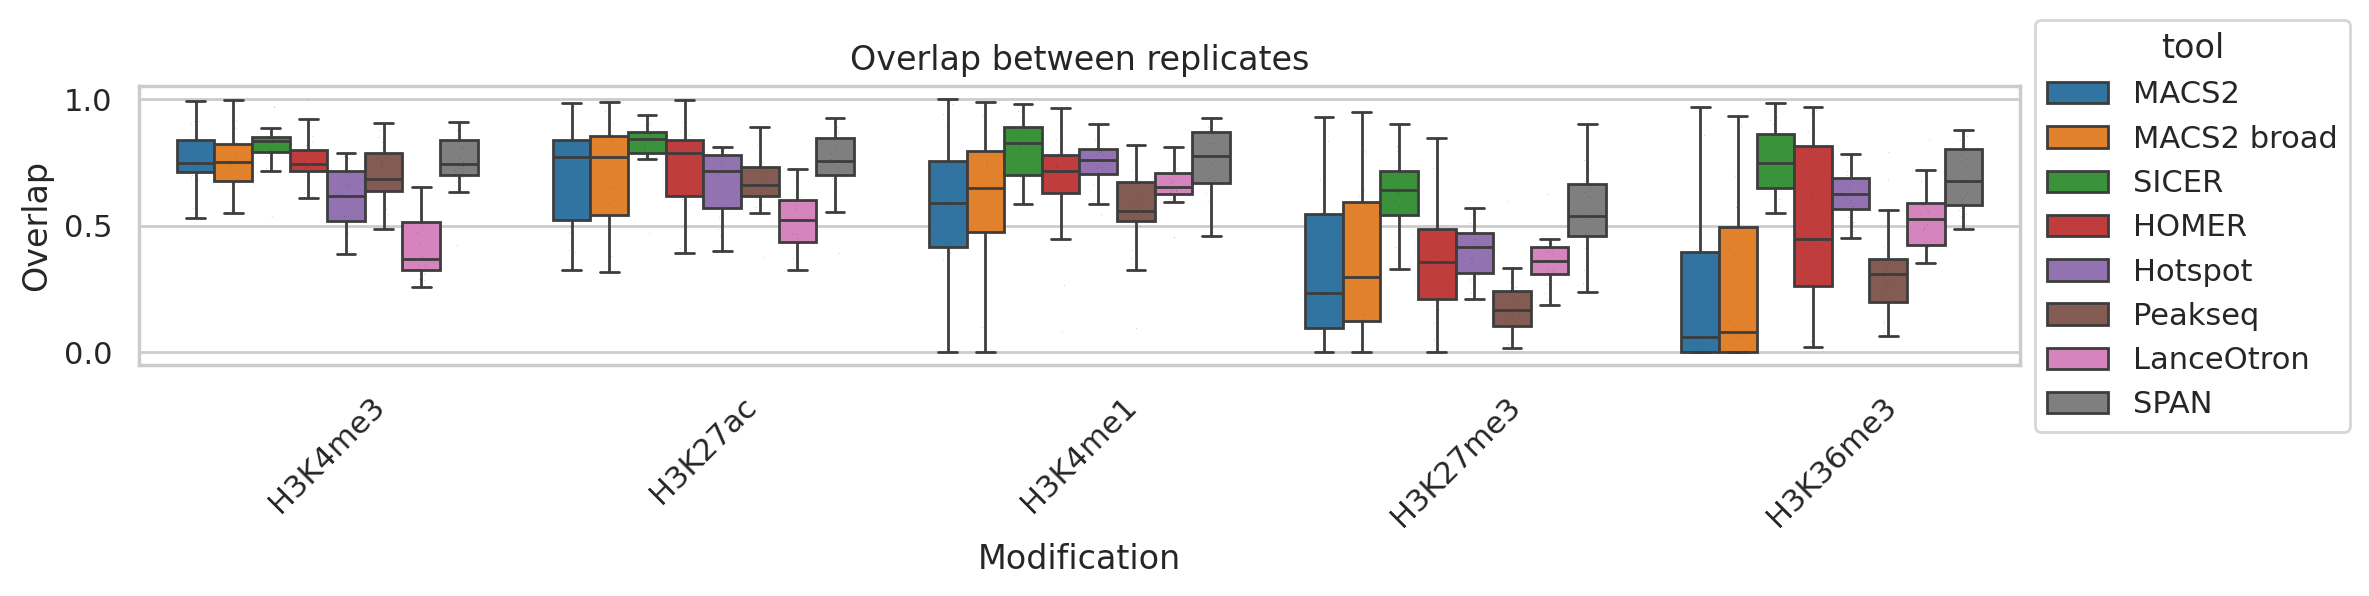

In [56]:
print('All')
sns.set_style("whitegrid")

plt.figure(figsize=(12, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=TOOLS,
            showfliers=False,
            ax=ax)
sns.stripplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=0.2, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=TOOLS,
              legend=False,
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE + Roadmap


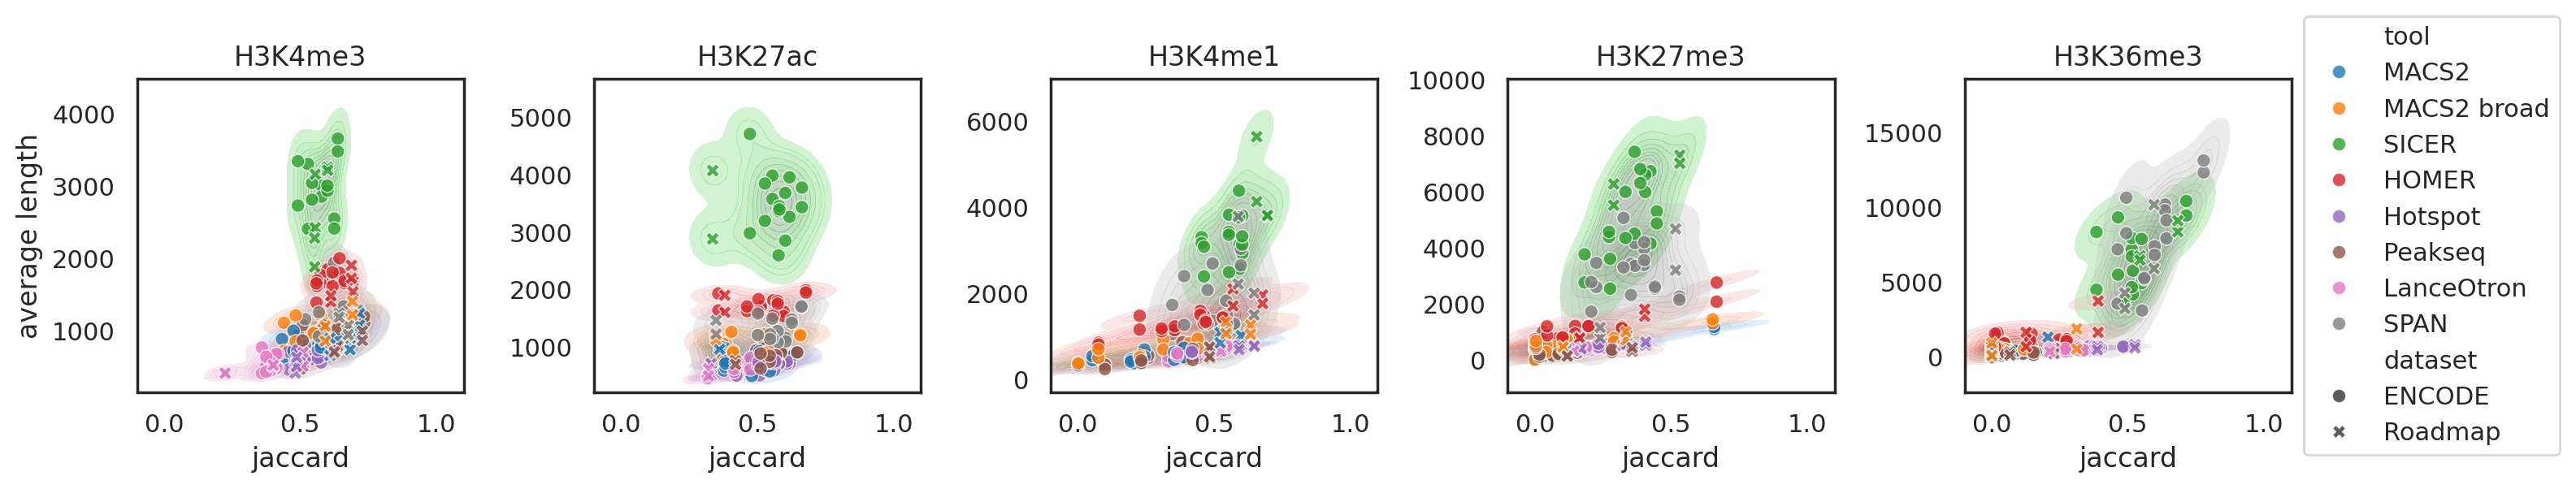

In [57]:
print('ENCODE + Roadmap')
sns.set_style("white")
# t = df_jaccard_avg_len_encode
df_jaccard_avg_len_encode['dataset'] = 'ENCODE'
df_jaccard_avg_len_immune['dataset'] = 'Roadmap'
t = pd.concat([df_jaccard_avg_len_encode, df_jaccard_avg_len_immune]).reset_index(drop=True)
plt.figure(figsize=(16, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.kdeplot(
        t[t['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.3,
        common_norm=False, common_grid=False,
        thresh=.05,
        fill=True,
        ax=ax,
    )
    sns.scatterplot(
        t[t['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        style='dataset',
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    # ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Jaccard ABF

In [58]:
df_abf_reps = compute_reps_overlap(df_abf_peaks)
df_abf_reps.sample(5)

  0%|          | 0/80 [00:00<?, ?it/s]

H3K27ac OD HOMER 20
H3K27ac OD Hotspot 20
H3K27ac OD LanceOtron 20
H3K27ac OD MACS2 20
H3K27ac OD MACS2 broad 20
H3K27ac OD Peakseq 20
H3K27ac OD SICER 20
H3K27ac OD SPAN 20
H3K27ac YD HOMER 18
H3K27ac YD Hotspot 18
H3K27ac YD LanceOtron 18
H3K27ac YD MACS2 18
H3K27ac YD MACS2 broad 18
H3K27ac YD Peakseq 18
H3K27ac YD SICER 18
H3K27ac YD SPAN 18
H3K27me3 OD HOMER 19
H3K27me3 OD Hotspot 19
H3K27me3 OD LanceOtron 19
H3K27me3 OD MACS2 19
H3K27me3 OD MACS2 broad 19
H3K27me3 OD Peakseq 19
H3K27me3 OD SICER 19
H3K27me3 OD SPAN 19
H3K27me3 YD HOMER 13
H3K27me3 YD Hotspot 13
H3K27me3 YD LanceOtron 13
H3K27me3 YD MACS2 13
H3K27me3 YD MACS2 broad 13
H3K27me3 YD Peakseq 13
H3K27me3 YD SICER 13
H3K27me3 YD SPAN 13
H3K36me3 OD HOMER 15
H3K36me3 OD Hotspot 15
H3K36me3 OD LanceOtron 15
H3K36me3 OD MACS2 15
H3K36me3 OD MACS2 broad 15
H3K36me3 OD Peakseq 15
H3K36me3 OD SICER 15
H3K36me3 OD SPAN 15
H3K36me3 YD HOMER 15
H3K36me3 YD Hotspot 15
H3K36me3 YD LanceOtron 15
H3K36me3 YD MACS2 15
H3K36me3 YD MAC

modification cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
6283     H3K36me3   YD        SICER  YD18  YD19   42001   335292999   26730   
4624     H3K27me3   YD        SICER  YD17  YD20   36596   213070004   17369   
5902     H3K36me3   YD        MACS2  YD10   YD6  154949    42538194  287021   
9580      H3K4me3   YD      Hotspot  YD11   YD9  465010   153326219  318957   
8022      H3K4me1   YD  MACS2 broad   YD5   YD9  146307    32617363  171776   

      peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
6283   404125670           37785           23099          316036969  0.746459  
4624    95237831           12729           14253           75855454  0.326327  
5902   115751245          136963          108375           36540228  0.300127  
9580   121221106           97334           93645           46770973  0.205337  
8022    47052677           86883           79631           17520241  0.281903

ABF


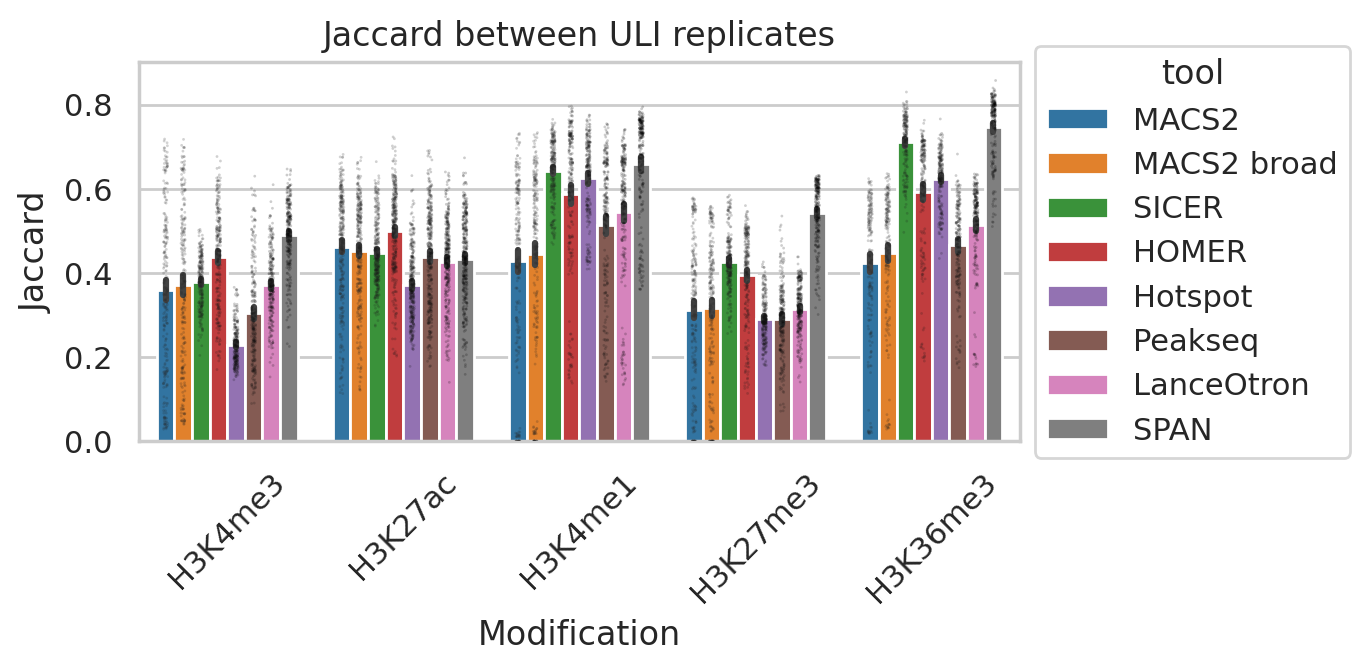

In [59]:
print('ABF')
sns.set_style("whitegrid")
plt.figure(figsize=(7, 3.5))
ax = plt.axes()
sns.barplot(data=df_abf_reps, x='modification', hue='tool', y='jaccard',
            order=MODIFICATIONS,
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            # capsize=.2, err_kws={'linewidth': 2},
            ax=ax)
sns.stripplot(data=df_abf_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=1, palette='dark:black', alpha=0.2,
              order=MODIFICATIONS,
              hue_order=TOOLS,
              legend=False,
              ax=ax)
ax.set_title('Jaccard between ULI replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# END